In [28]:
from warnings import filterwarnings

In [29]:
filterwarnings("ignore")

S&P 500 — фондовый индекс, в корзину которого включено 505 акций 500 избранных торгуемых на фондовых биржах США

In [30]:
import statsmodels.graphics.tsaplots as sgt
import pandas as pd
import numpy as np

data = pd.read_csv("/content/sp500.zip", parse_dates=["Date"], index_col=["Date"])
data.head()

,spx
Date,
1994-01-06,467.119995
1994-01-07,469.899994
1994-01-10,475.269989
1994-01-11,474.130005
1994-01-12,474.170013


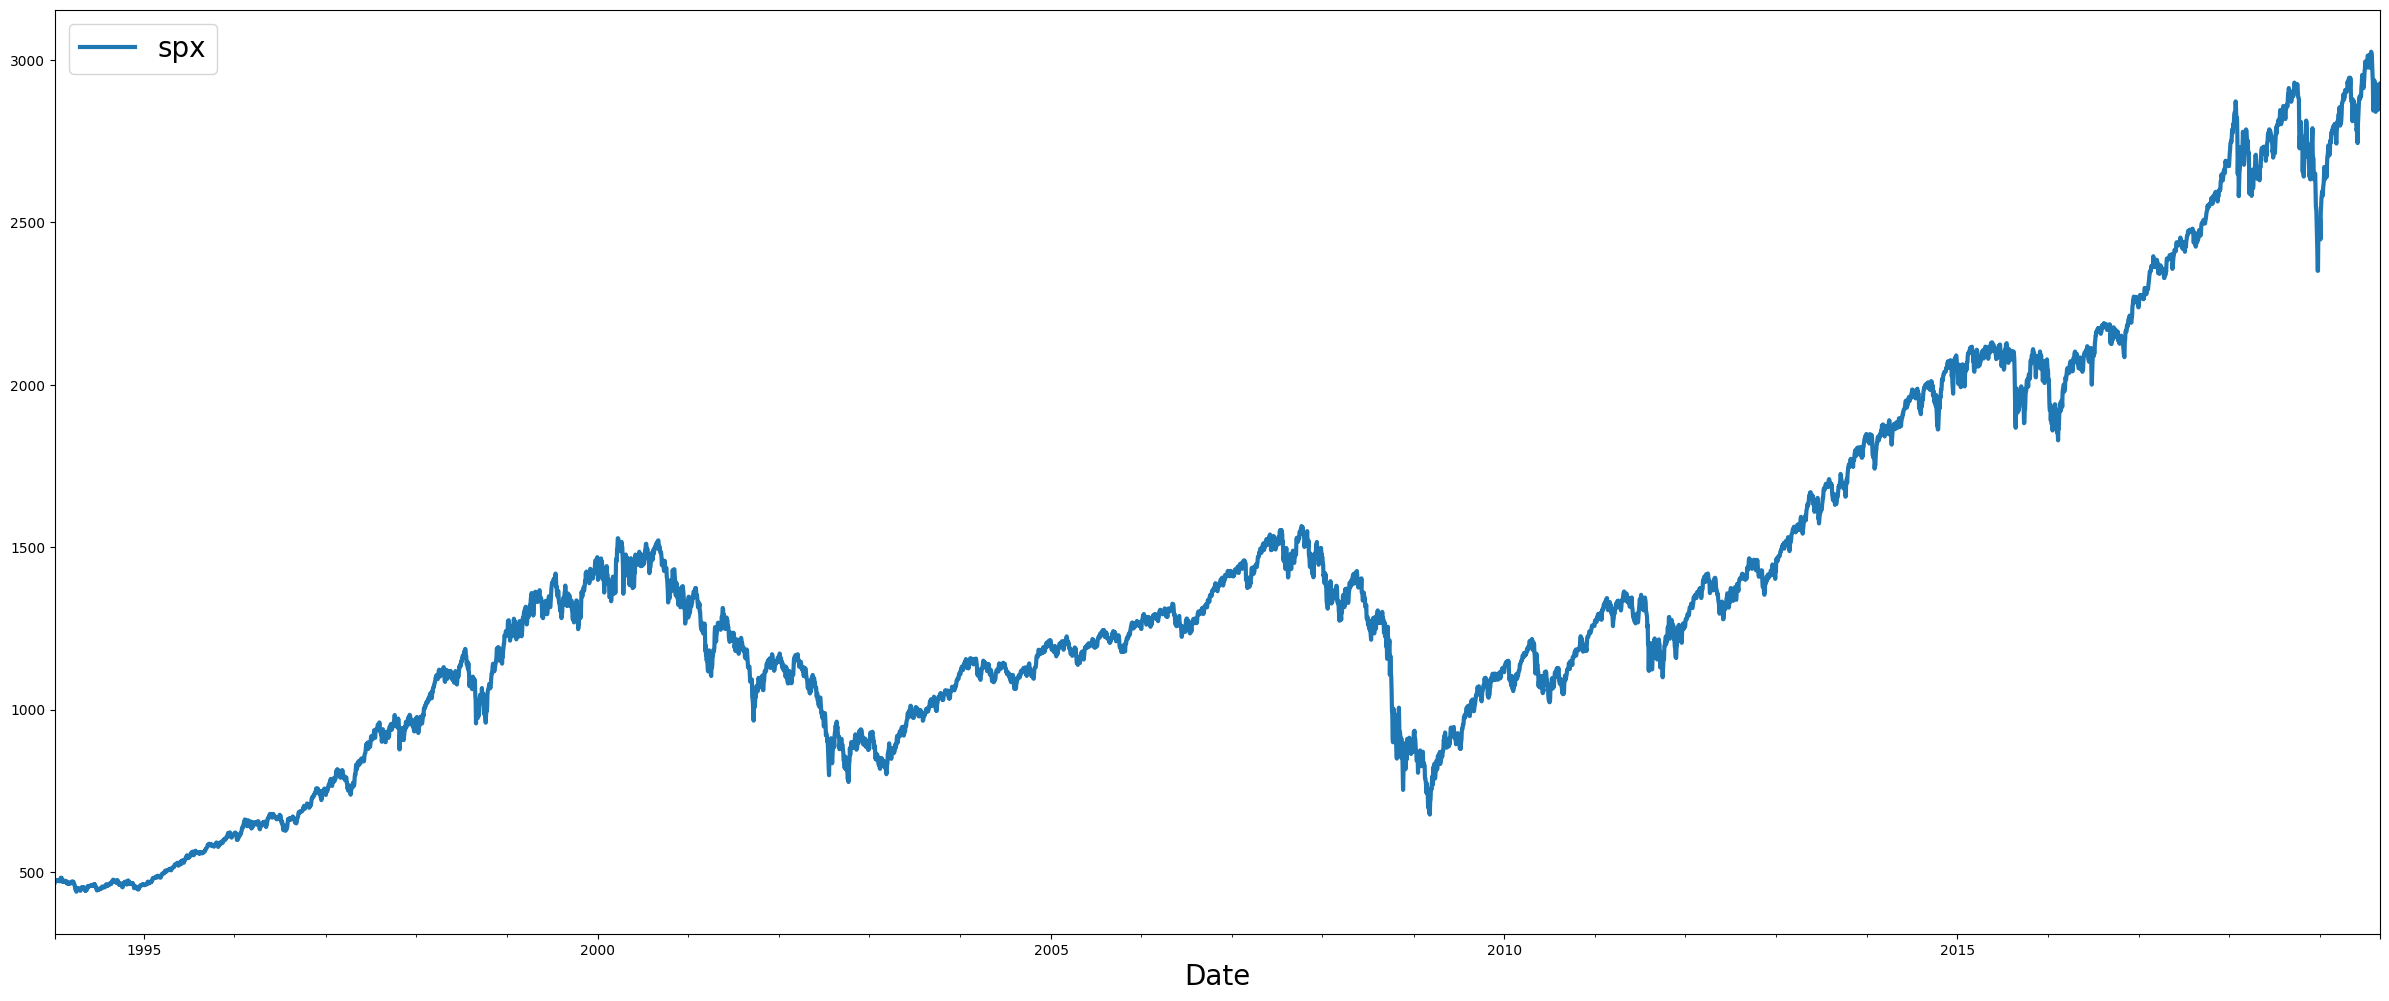

In [31]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

data.plot()
plt.show()

In [32]:
train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]
train_df.shape, test_df.shape

((6518, 1), (174, 1))

In [ ]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = 18, 5

for year in set(train_df.index.year):
    plt.plot(train_df[["spx"]].loc[train_df.index.year == year])
    plt.title(str(year), size=24)
    plt.show()

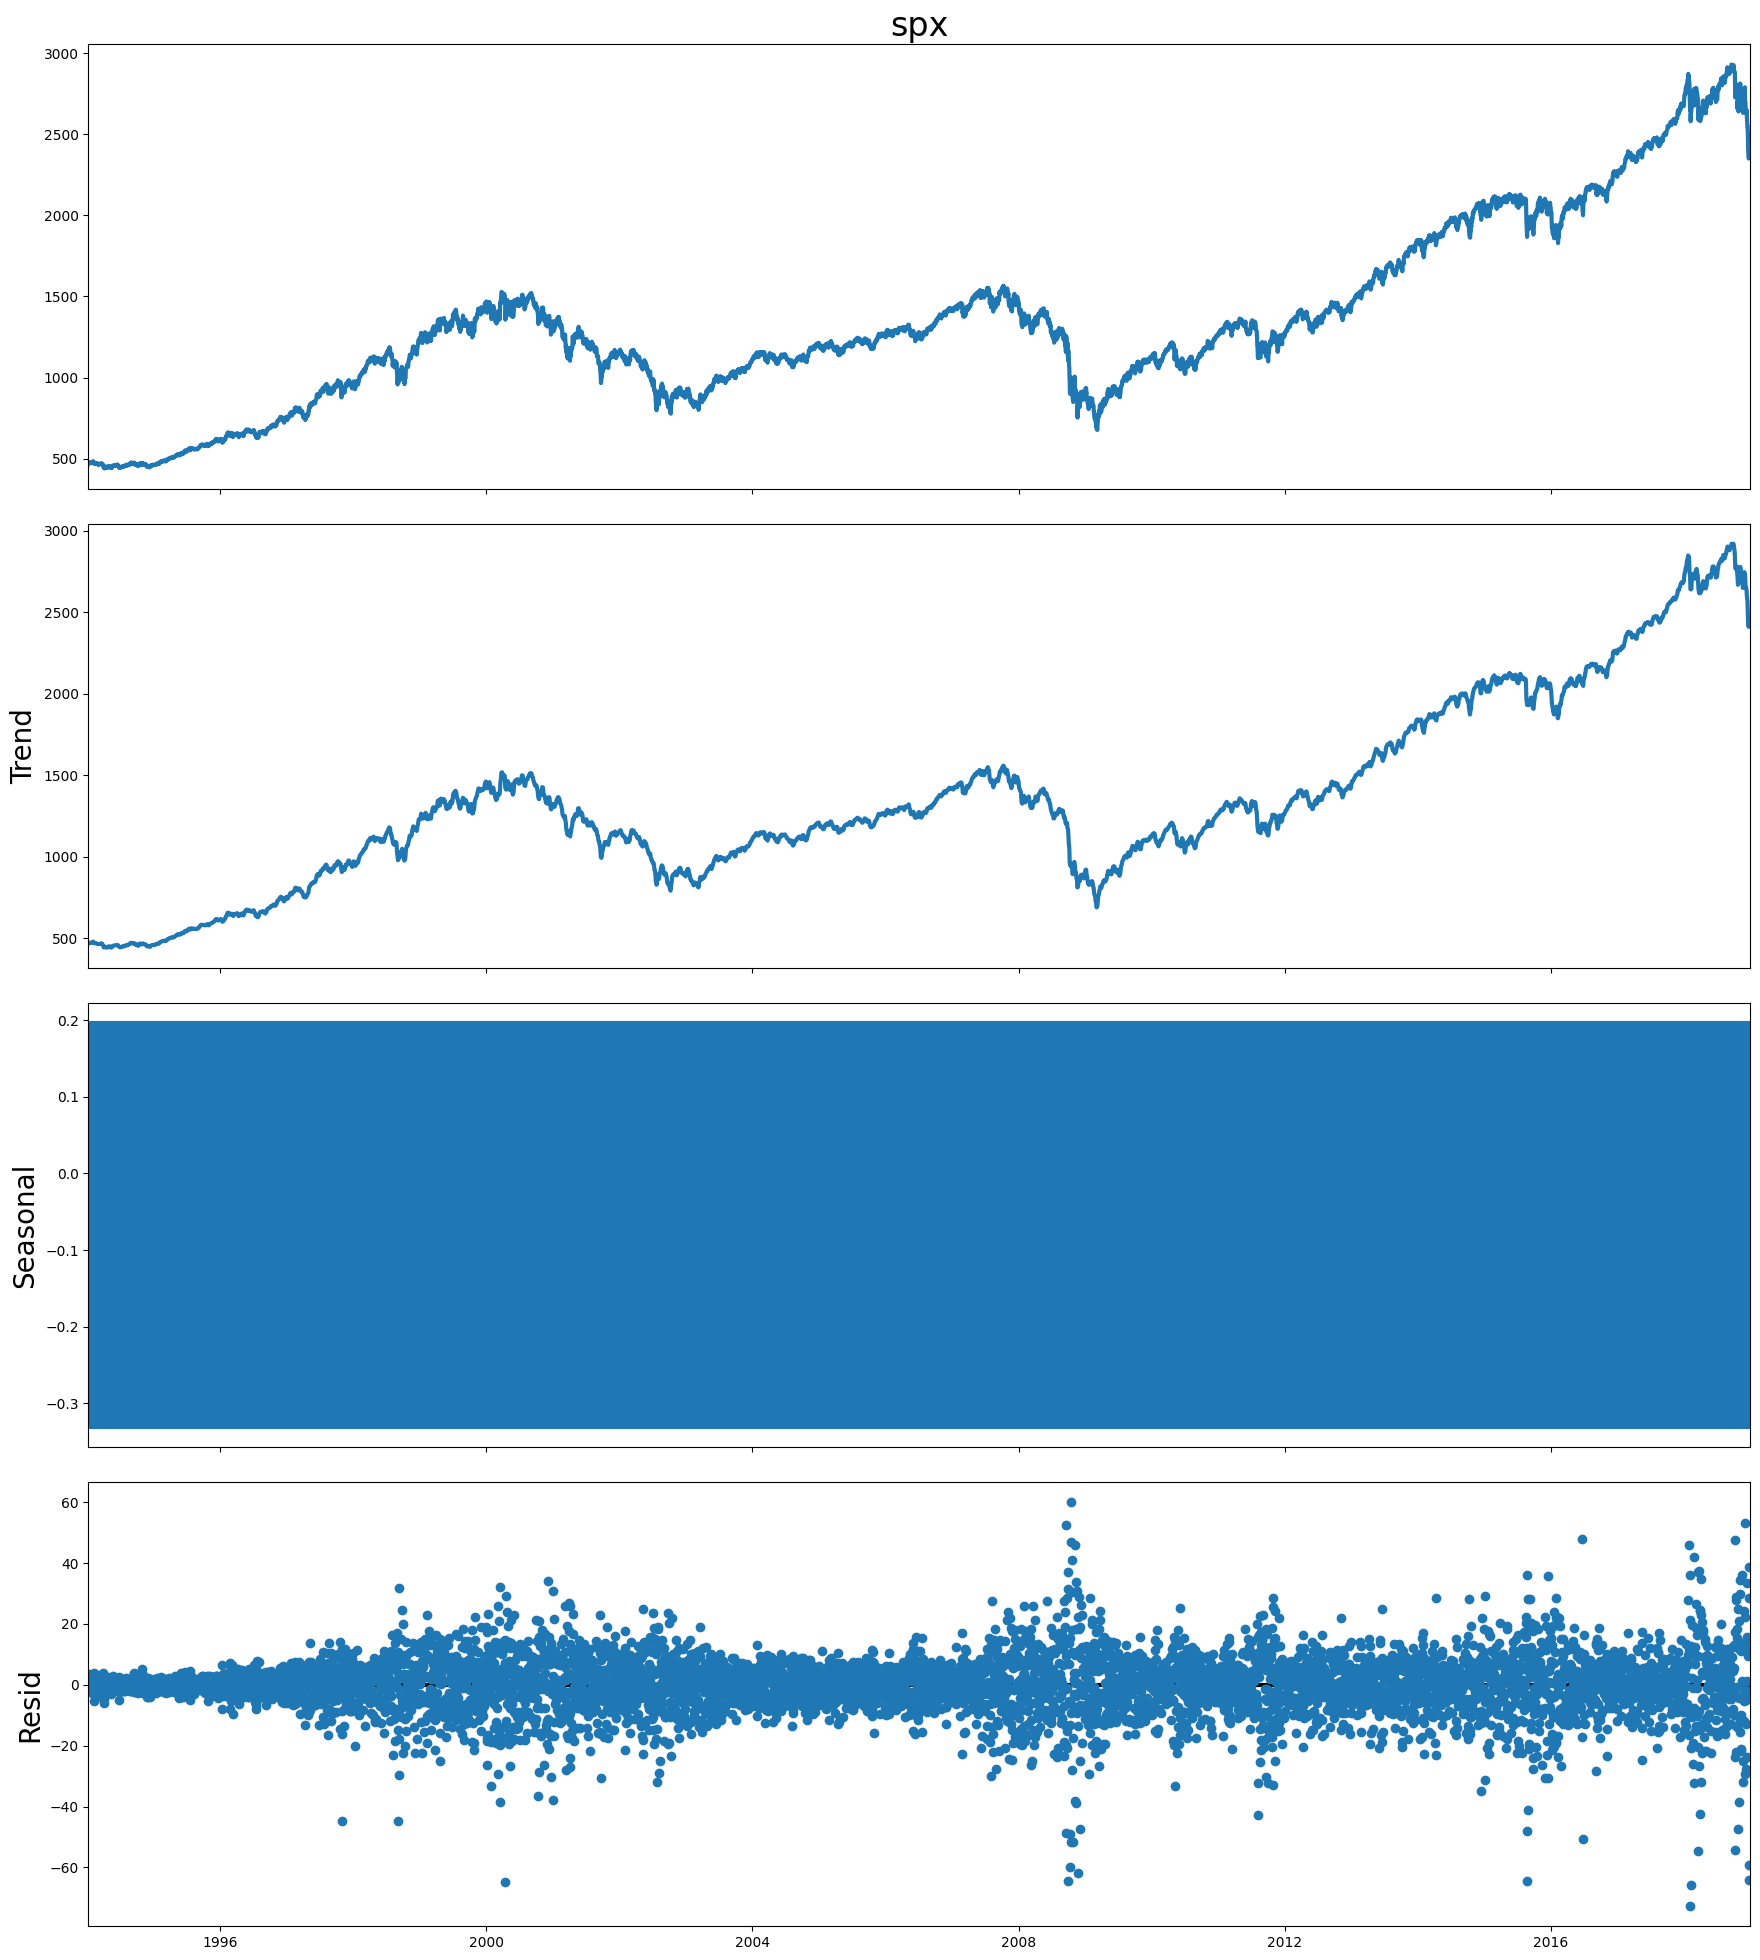

In [34]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df.spx)
result.plot()
plt.show()

Сезонная компонента выглядит очень странно, посмотрим на первые 20 значений

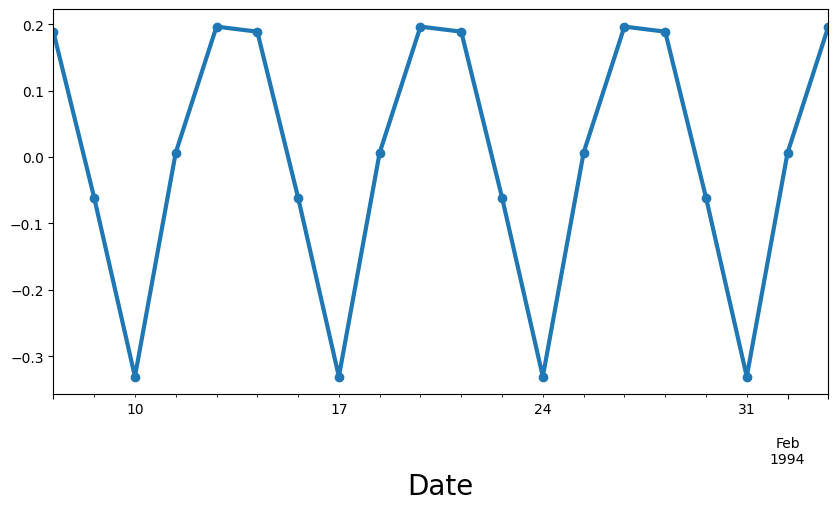

In [35]:
plt.rcParams["figure.figsize"] = 10, 5
result.seasonal[:20].plot(marker="o")
plt.show()

График четко показывает повторяющийся цикл каждые 5 периодов. Это довольно логично, поскольку наши данные — это данные о ценах на акции. Мы наблюдаем и собираем данные о ценах на акции каждый рабочий день недели. Это означает, что данные представляли собой еженедельную сезонность, а неделя была рабочей неделей (5 дней в неделю)

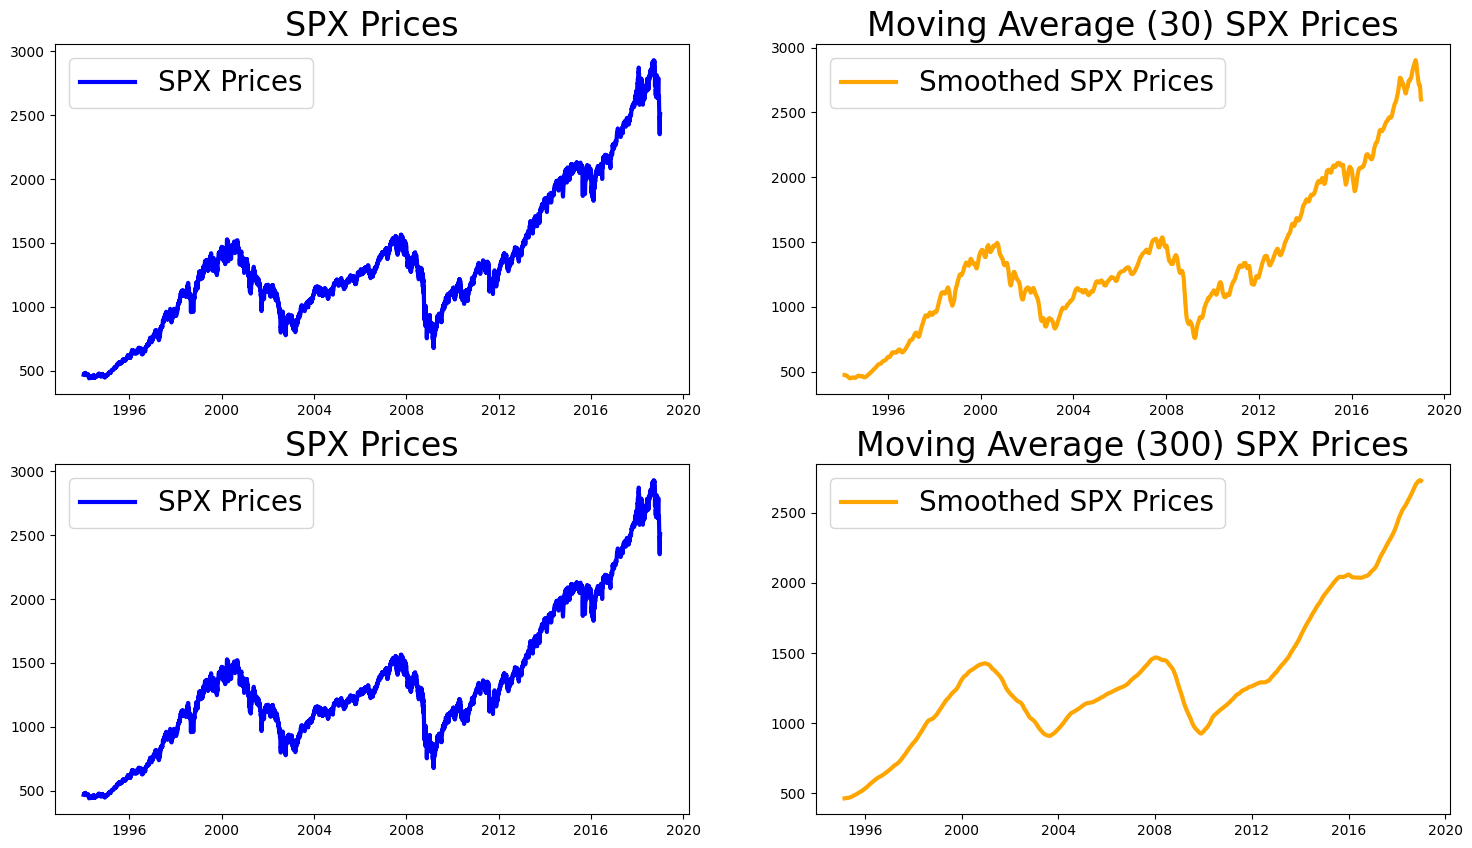

In [36]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(train_df.spx, color="blue", label="SPX Prices")
ax[0, 0].set_title("SPX Prices", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df.spx.rolling(window=30).mean(),
    color="orange",
    label="Smoothed SPX Prices",
)

ax[0, 1].set_title("Moving Average (30) SPX Prices", size=24)
ax[0, 1].legend()


# Окно в год (Window = 300)
ax[1, 0].plot(train_df.spx, color="blue", label="SPX Prices")
ax[1, 0].set_title("SPX Prices", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df.spx.rolling(window=300).mean(),
    color="orange",
    label="Smoothed SPX Prices",
)

ax[1, 1].set_title("Moving Average (300) SPX Prices", size=24)
ax[1, 1].legend()

plt.show()

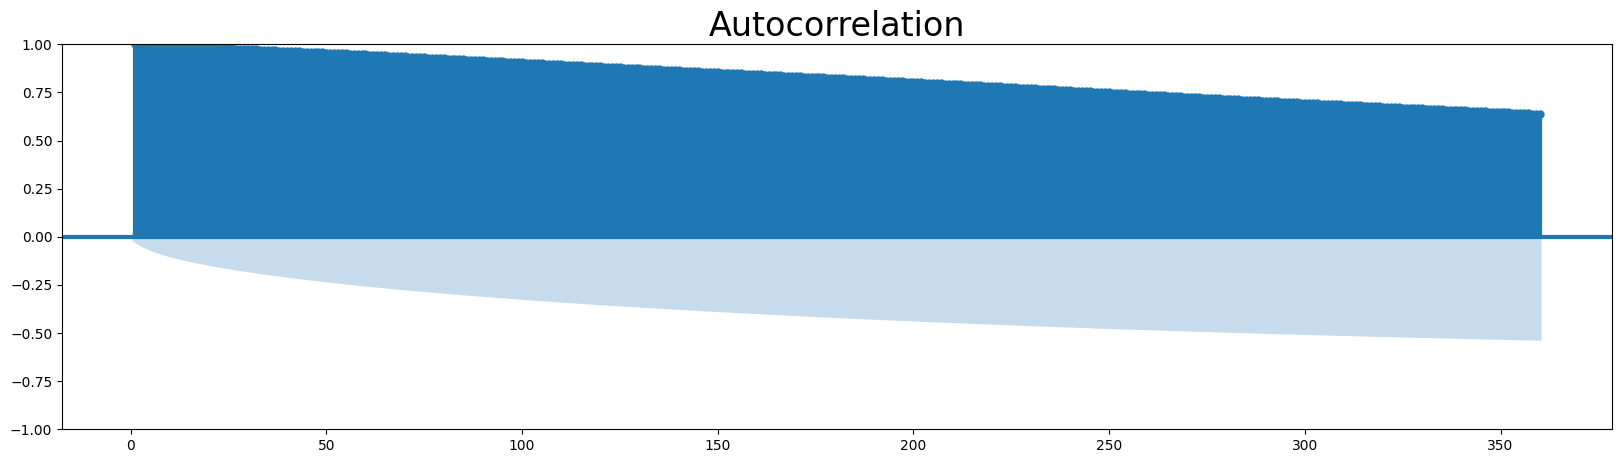

In [37]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_acf(train_df.spx, lags=360, zero=False)
plt.show()

цены SPX сильно коррелированы. Корреляция сохраняется даже по прошествии года.

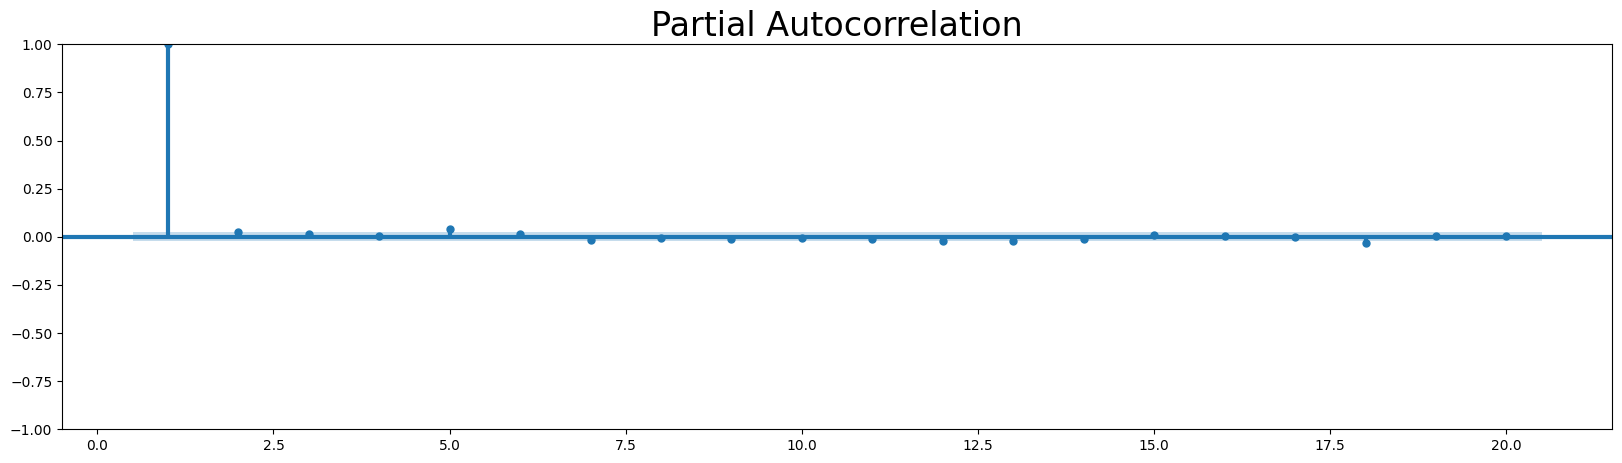

In [38]:
import statsmodels.graphics.tsaplots as sgt

plt.rcParams["figure.figsize"] = 20, 5
sgt.plot_pacf(train_df.spx, lags=20, method="ywm", zero=False)
plt.show()

Эти графики показывают, как данные коррелируют с запаздывающей версией самих себя.
В отличие от того, что предлагали графики ACF, цены SPX с лагом не приносят никакой новой информации. В таких ситуация параметр p выбирается =1


In [39]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df["spx"])

(-0.3312809396965244,
 0.9209556878912157,
 10,
 6507,
 {'1%': -3.4313553606207843,
  '5%': -2.8619842833301883,
  '10%': -2.56700648865667},
 53000.32567590042)

Статистика теста больше всех критических значений, поэтому нулевую гипотезу ($H_0$) нельзя отвергнуть.

Поэтому цены SPX не являются стационарными

In [40]:
def plot_acf_pacf(series):
    plt.rcParams["figure.figsize"] = 18, 5

    fig, axes = plt.subplots(1, 2)

    sgt.plot_acf(series, ax=axes[0], lags=40)
    sgt.plot_pacf(series, ax=axes[1], lags=40, method="ywm")
    plt.show()

## Дифференцирование ряда
$y\_new_t = y_t - y_{t-1}$

where,
- $y\_new_t$: Дифференцированное значение ряда $t$
- $y_t$: Фактическое значение ряда $t$
- $y_{t-1}$: Фактическое значение ряда $t-1$

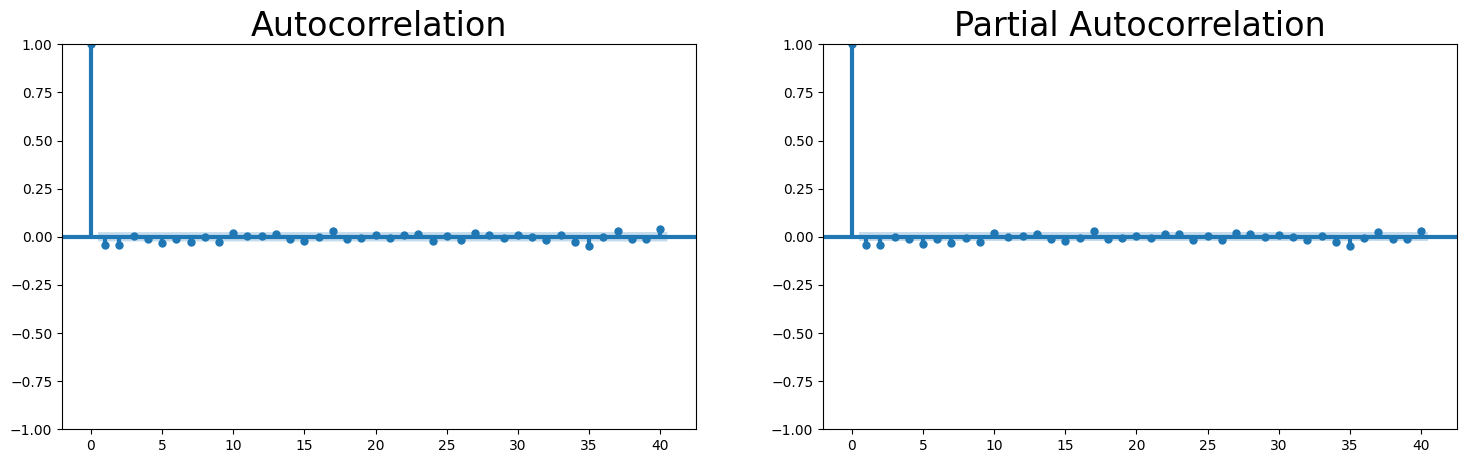

(-27.326250201731145,
 0.0,
 9,
 6507,
 {'1%': -3.4313553606207843,
  '5%': -2.8619842833301883,
  '10%': -2.56700648865667},
 52991.2781500849)

In [41]:
plot_acf_pacf(train_df["spx"].diff().dropna())
adfuller(train_df["spx"].diff().dropna())

Первые разности являются стационарными

## ARIMA, SARIMA

Начнем построение модели **ARIMA** со следующими параметрами:

- p = 1
- d = 1
- q = 1

Если рассматривать сезонную модель (**SARMA**), то в модель можно добавить следующие параметры.

- m = 5 (будучи рыночным индексом, данные, скорее всего, будут иметь еженедельно повторяющиеся паттерны, как видно из визуализации)
- P = 1
- D = 1
- Q = 1

In [42]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["spx"].dropna(), order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6518
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -26625.675
Date:                Sun, 10 Dec 2023   AIC                          53257.350
Time:                        12:51:29   BIC                          53277.697
Sample:                    01-06-1994   HQIC                         53264.387
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7598      0.048     15.908      0.000       0.666       0.853
ma.L1         -0.8016      0.044    -18.385      0.000      -0.887      -0.716
sigma2       207.1124      1.766    117.304      0.000     203.652     210.573
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12081.79
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(train_df["spx"].dropna(), order=(1, 1, 1))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 6518
Model:               SARIMAX(1, 1, 1)   Log Likelihood              -26625.675
Date:                Sun, 10 Dec 2023   AIC                          53257.350
Time:                        12:51:31   BIC                          53277.697
Sample:                    01-06-1994   HQIC                         53264.387
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7598      0.048     15.908      0.000       0.666       0.853
ma.L1         -0.8016      0.044    -18.385      0.000      -0.887      -0.716
sigma2       207.1124      1.766    117.304      0.000     203.652     210.573
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):             12081.79
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               1.93   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Второй столбец раздела I содержит некоторые полезные показатели, которые используются для сравнения различных моделей ARIMA. Как правило, модель с более высоким логарифмическим правдоподобием или более низким IC (AIC, BIC или HQIC) лучше, и наоборот.

In [44]:
seas_model = SARIMAX(
    train_df["spx"].dropna(), order=(1, 1, 2), seasonal_order=(1, 1, 2, 5)
)

seas_model_fit = seas_model.fit()
seas_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               spx   No. Observations:                 6518
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 5)   Log Likelihood              -26617.829
Date:                           Sun, 10 Dec 2023   AIC                          53249.657
Time:                                   12:52:26   BIC                          53297.127
Sample:                               01-06-1994   HQIC                         53266.074
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1565      0.169      0.924      0.355      -0.175       0.488
ma.L1         -0.1993      0.169     -1.183      0.237      -0.530       0.131
ma.L2         -0.0333      0.011     -2.898      0.004      -0.056      -0.011
ar.S.L5       -0.7732      0.081     -9.558      0.000      -0.932      -0.615
ma.S.L5       -0.2578      0.085     -3.031      0.002      -0.425      -0.091
ma.S.L10      -0.7414      0.086     -8.656      0.000      -0.909      -0.574
sigma2       206.7707      1.991    103.839      0.000     202.868     210.674
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11680.21
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               1.91   Skew:                            -0.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [45]:
pred_df = pd.DataFrame(index=data.index)

pred_df["model_preds"] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["spx"] = data["spx"]

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx"]

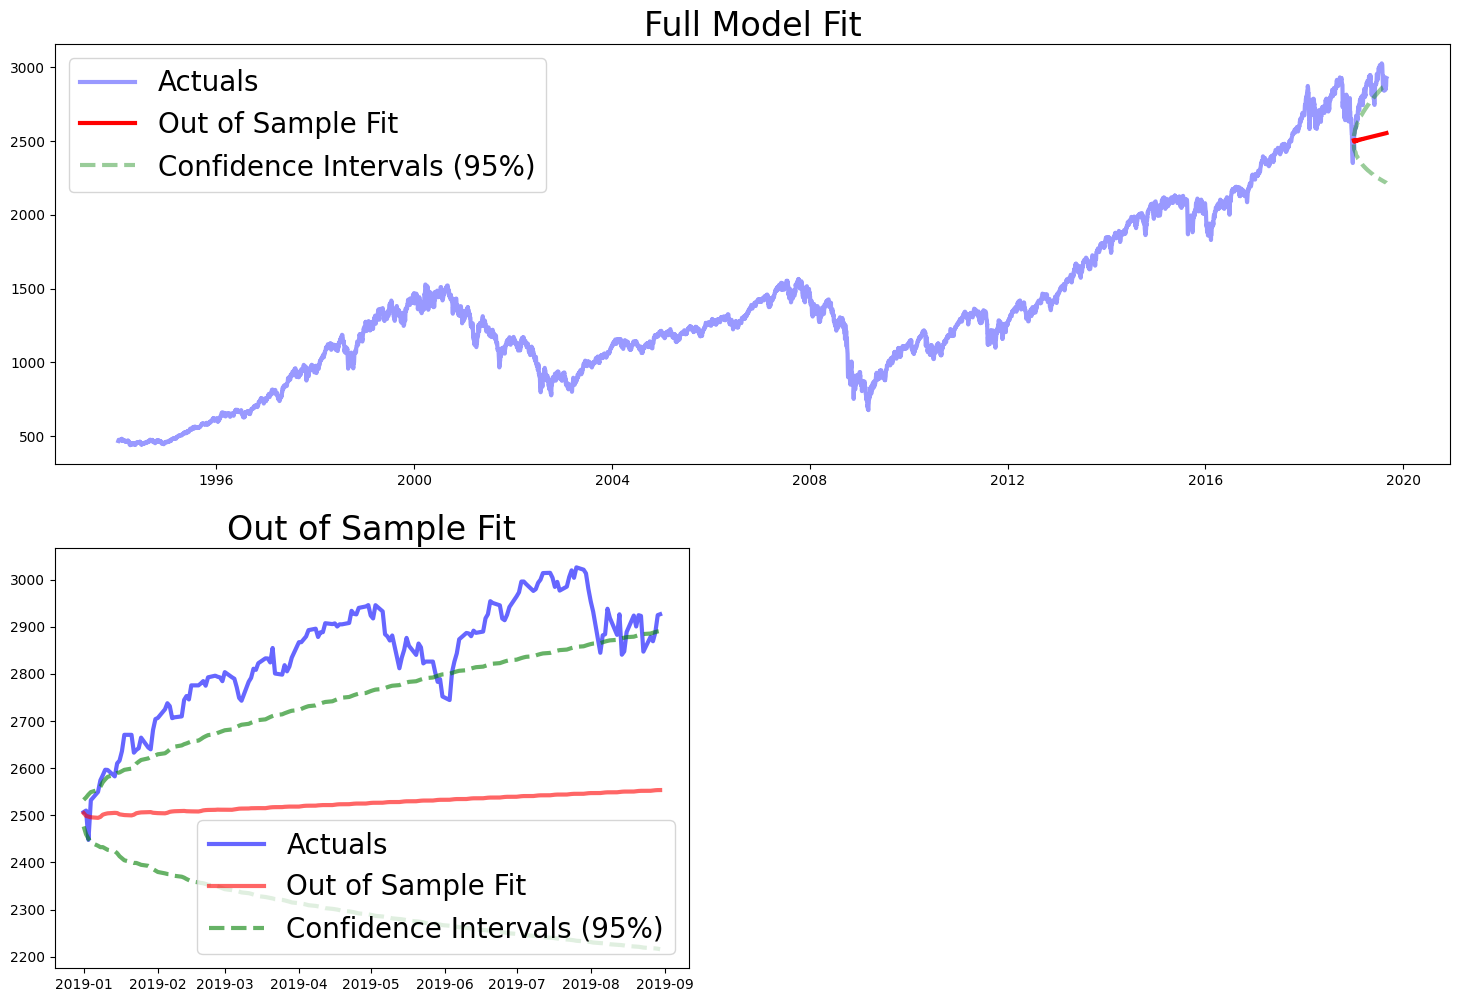

In [46]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["spx"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["spx"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

In [47]:
pip install pmdarima

In [48]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=inf, Time=27.68 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=57943.325, Time=1.23 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=55834.625, Time=3.71 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=inf, Time=17.64 sec
 ARIMA(1,1,0)(0,1,0)[5]             : AIC=57939.123, Time=1.92 sec
 ARIMA(1,1,0)(2,1,0)[5]             : AIC=55138.362, Time=5.60 sec
 ARIMA(1,1,0)(2,1,1)[5]             : AIC=inf, Time=25.80 sec
 ARIMA(1,1,0)(1,1,1)[5]             : AIC=inf, Time=11.66 sec
 ARIMA(0,1,0)(2,1,0)[5]             : AIC=55142.946, Time=3.39 sec
 ARIMA(2,1,0)(2,1,0)[5]             : AIC=55124.504, Time=3.90 sec
 ARIMA(2,1,0)(1,1,0)[5]             : AIC=55827.531, Time=2.49 sec
 ARIMA(2,1,0)(2,1,1)[5]             : AIC=inf, Time=32.97 sec
 ARIMA(2,1,0)(1,1,1)[5]             : AIC=inf, Time=20.78 sec
 ARIMA(3,1,0)(2,1,0)[5]             : AIC=55125.927, Time=6.00 sec
 ARIMA(2,1,1)(2,1,0)[5]             : AIC=55141.9

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 6518
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 5)   Log Likelihood              -27557.252
Date:                           Sun, 10 Dec 2023   AIC                          55124.504
Time:                                   12:56:08   BIC                          55158.411
Sample:                               01-06-1994   HQIC                         55136.230
                                    - 12-31-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0335      0.008     -4.447      0.000      -0.048      -0.019
ar.L2         -0.0494      0.007     -7.204      0.000      -0.063      -0.036
ar.S.L5       -0.6999      0.007    -99.802      0.000      -0.714      -0.686
ar.S.L10      -0.3228      0.007    -43.233      0.000      -0.337      -0.308
sigma2       277.3268      2.423    114.438      0.000     272.577     282.077
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             11066.86
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.98   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Downsampling / Upsampling (Интерполяция)

In [49]:
print(data.shape)
data[(data.index > "2005-01-06") & (data.index < "2005-02-10")].head()

(6692, 1)


,spx
Date,
2005-01-07,1186.189941
2005-01-10,1190.250000
2005-01-11,1182.989990
2005-01-12,1187.699951
2005-01-13,1177.449951


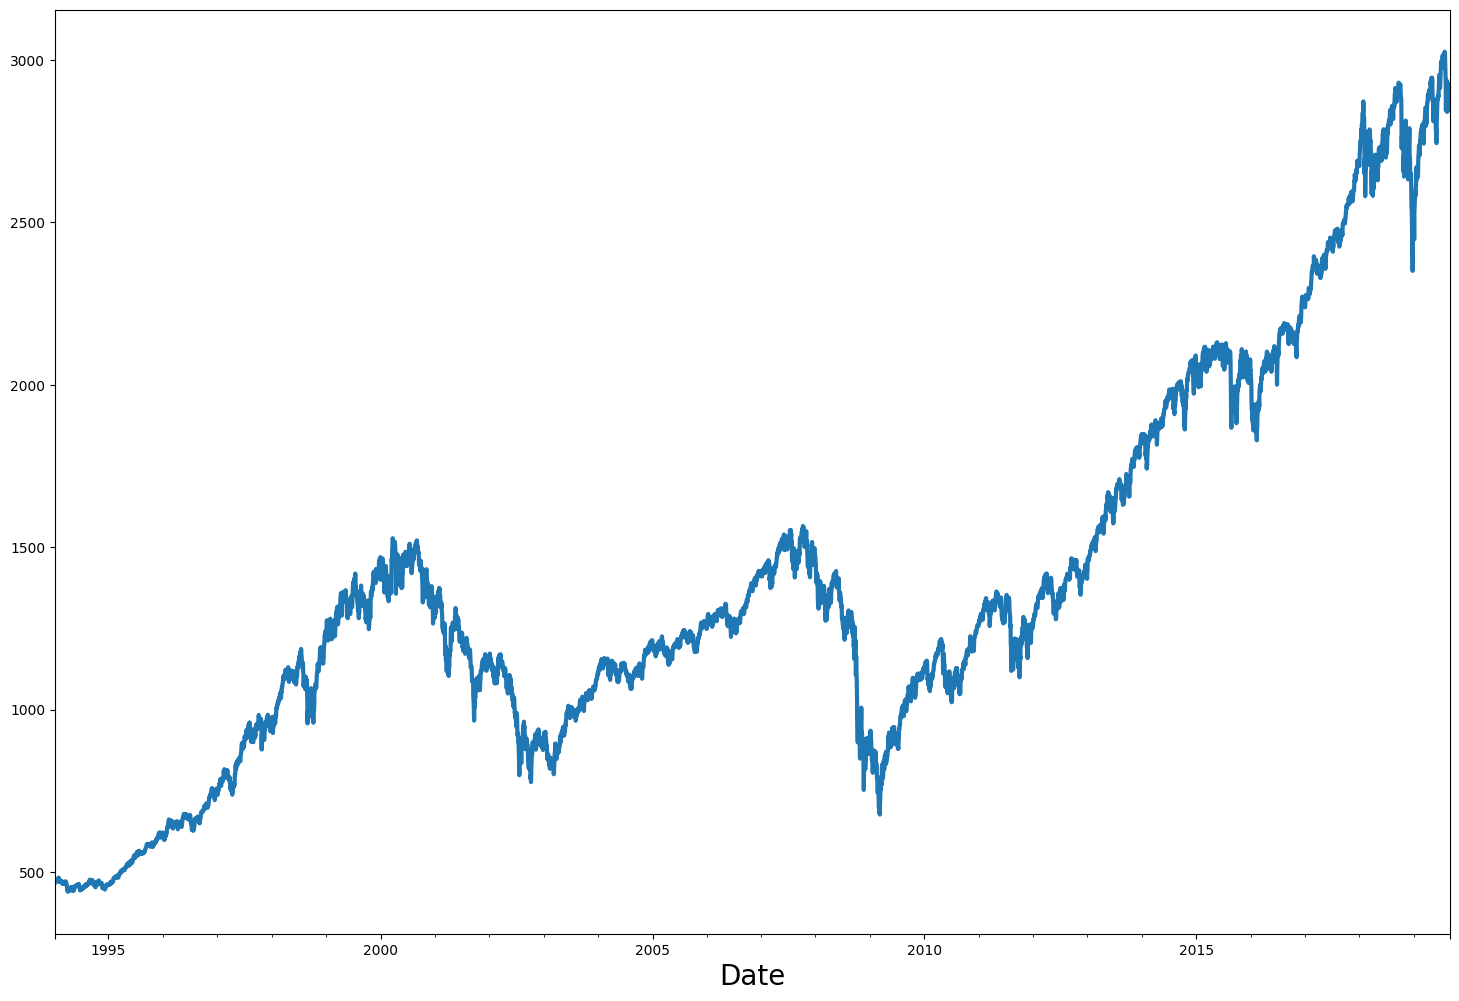

In [50]:
data.spx.plot()
plt.show()

(1339, 1)


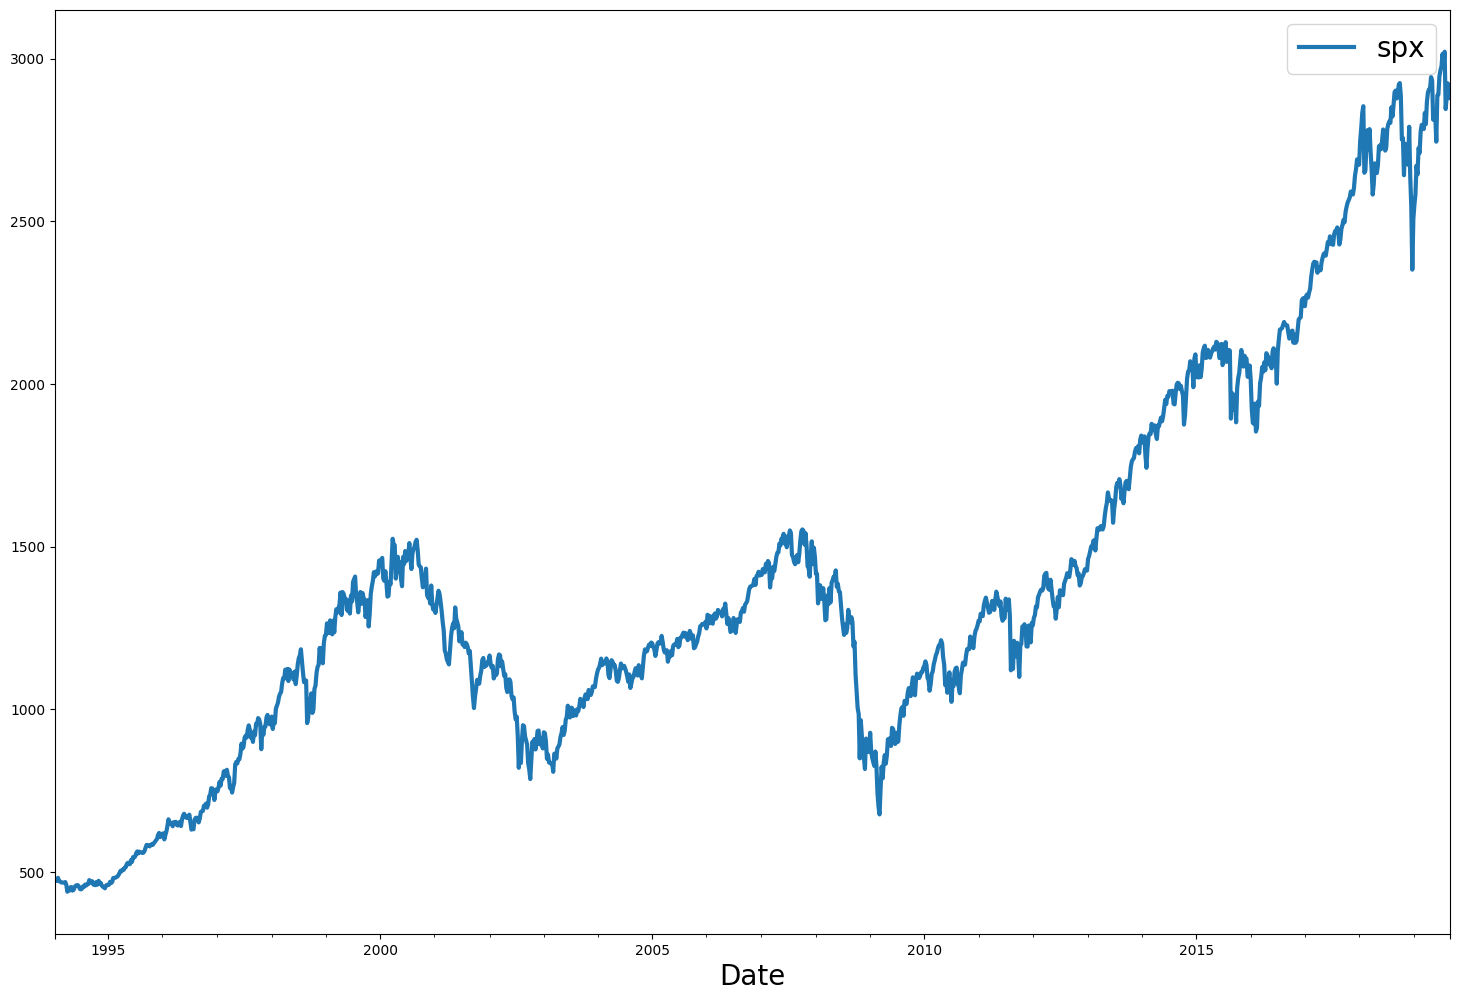

In [51]:
interpolated_data = pd.DataFrame(
    data.spx.resample("w-MON").interpolate(), columns=["spx"]
)

print(interpolated_data.shape)
interpolated_data.plot()
plt.show()

In [52]:
interpolated_data.head()

,spx
Date,
1994-01-10,475.269989
1994-01-17,473.299988
1994-01-24,471.970001
1994-01-31,481.609985
1994-02-07,471.760010


In [53]:
train_df = interpolated_data.loc[:"2018-12-31"]
test_df = interpolated_data.loc["2019-01-01":]
train_df.shape, test_df.shape

((1304, 1), (35, 1))

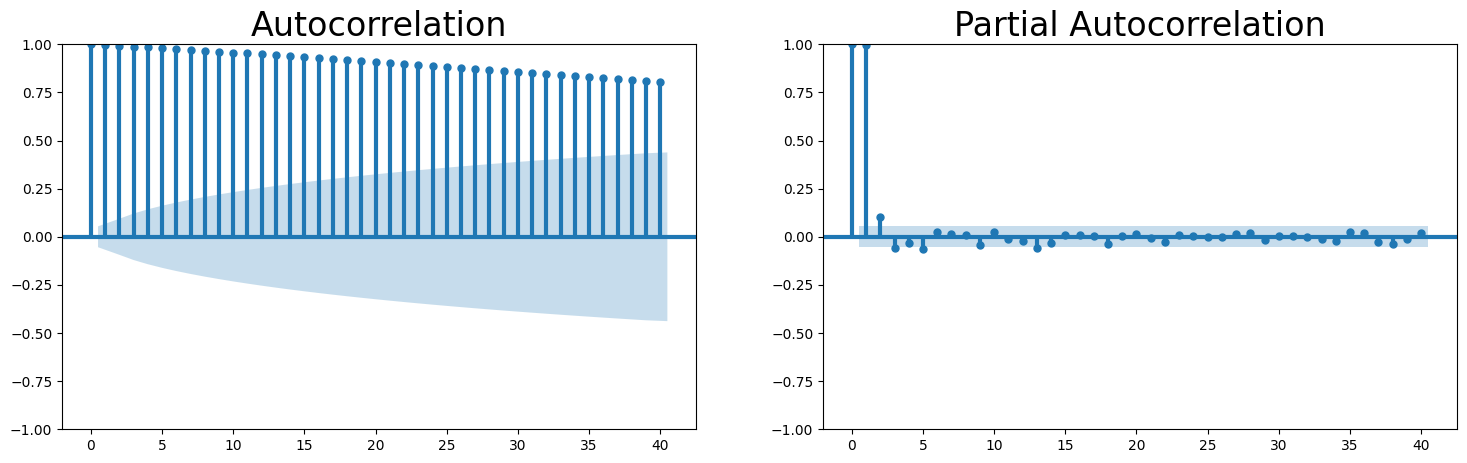

(-0.2607657143116782,
 0.9308801996019748,
 10,
 1293,
 {'1%': -3.4354175403897727,
  '5%': -2.8637778952086848,
  '10%': -2.5679614713589562},
 12512.497637173248)

In [54]:
import statsmodels.graphics.tsaplots as sgt

plot_acf_pacf(train_df["spx"].dropna())
adfuller(train_df["spx"].dropna())

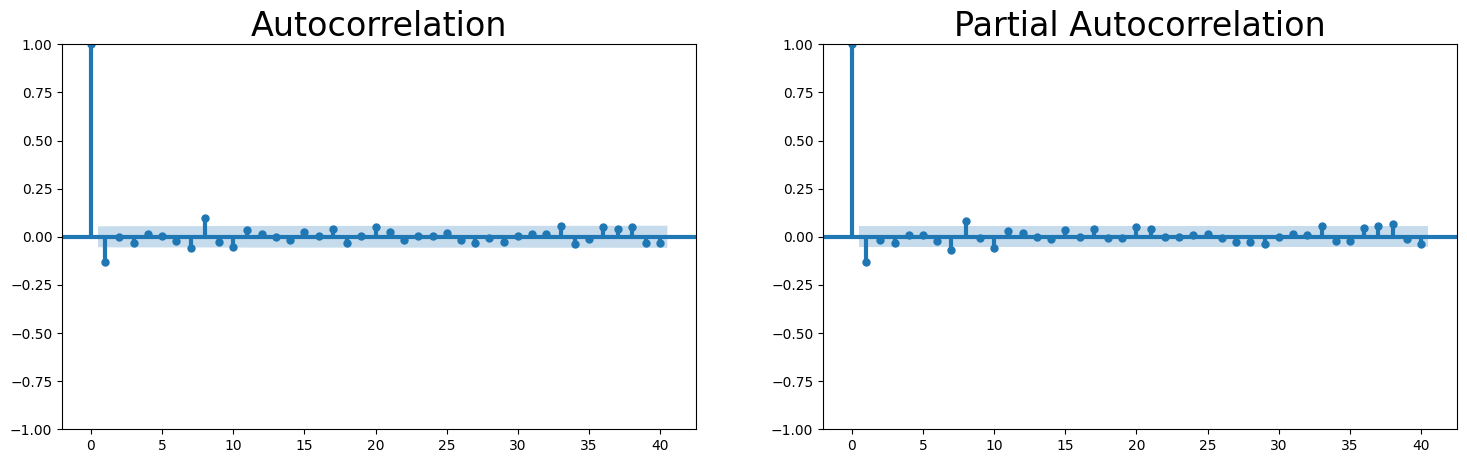

(-11.946377875600588,
 4.420358877552662e-22,
 9,
 1293,
 {'1%': -3.4354175403897727,
  '5%': -2.8637778952086848,
  '10%': -2.5679614713589562},
 12501.713967337682)

In [55]:
plot_acf_pacf(train_df["spx"].diff().dropna())
adfuller(train_df["spx"].diff().dropna())

In [56]:
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt

arima_model = ARIMA(train_df["spx"].dropna(), order=(1, 1, 1))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    spx   No. Observations:                 1304
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -6359.035
Date:                Sun, 10 Dec 2023   AIC                          12724.070
Time:                        12:56:11   BIC                          12739.587
Sample:                    01-10-1994   HQIC                         12729.891
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0215      0.137      0.157      0.875      -0.247       0.290
ma.L1         -0.1545      0.132     -1.173      0.241      -0.413       0.104
sigma2      1015.0734     20.021     50.701      0.000     975.833    1054.314
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):              2373.55
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               2.31   Skew:                            -1.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [57]:
pred_df = pd.DataFrame(index=interpolated_data.index)

pred_df["model_preds"] = arima_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["spx"] = data["spx"]

forecast = arima_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx"]

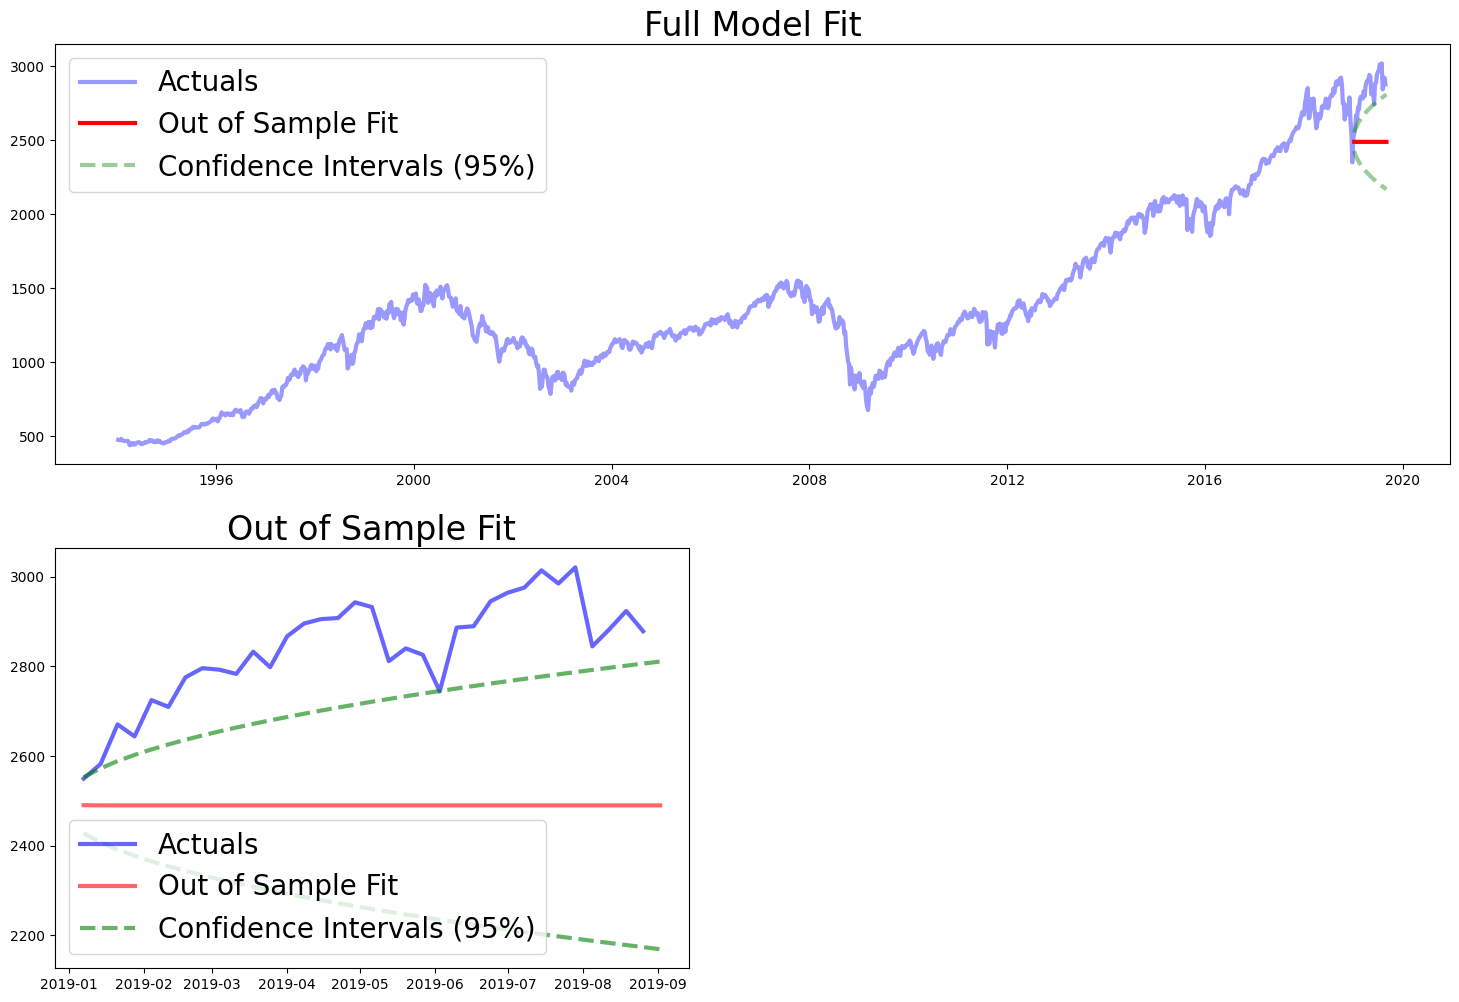

In [58]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["spx"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["spx"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

## Волатильность

 **Volatility** at time **t**  

$Vol(t) = |\frac{Price(t) - Price(t-1)}{Price(t-1)} * 100|$

In [59]:
# data["spx_vol"] = (data.spx - data.spx.shift(1))/data.spx.shift(1)
data["spx_vol"] = data.spx.pct_change(1).mul(100).abs()
data["spx_vol"].head()

Date
1994-01-06         NaN
1994-01-07    0.595136
1994-01-10    1.142795
1994-01-11    0.239860
1994-01-12    0.008438
Name: spx_vol, dtype: float64

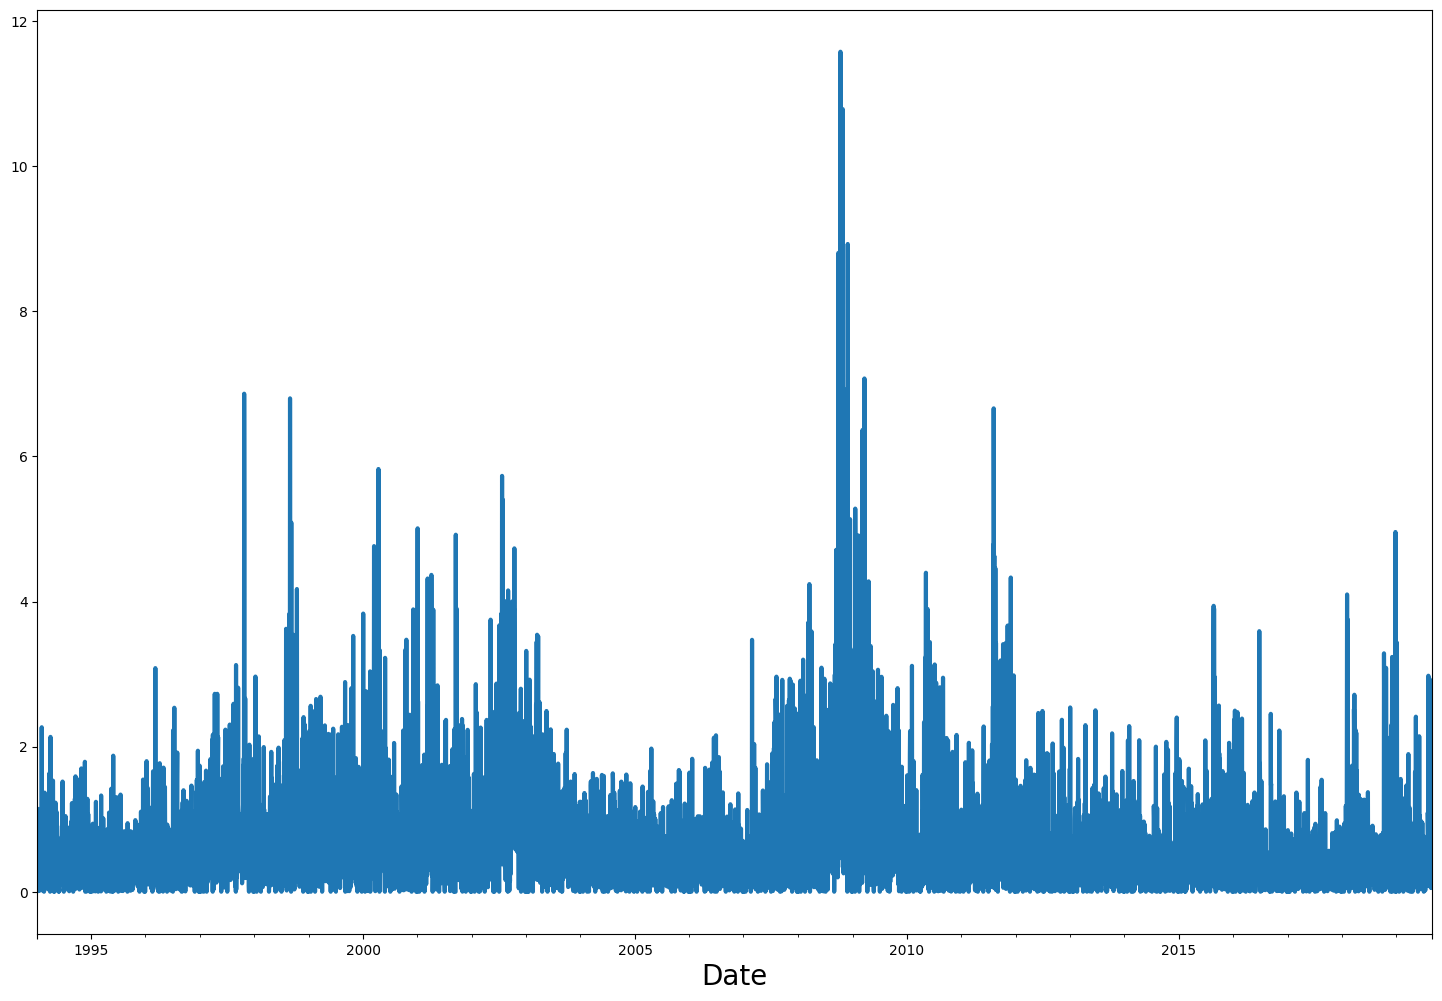

In [60]:
data["spx_vol"].plot()
plt.show()

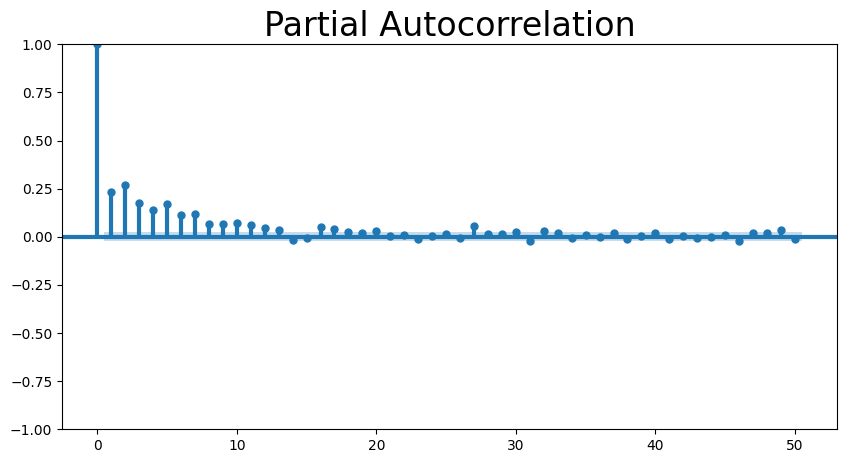

In [61]:
from matplotlib import pyplot as plt

train_df = data.loc[:"2018-12-31"]
test_df = data.loc["2019-01-01":]

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df.spx_vol[1:], lags=50, method="ywm")
plt.show()

In [62]:
adfuller(train_df.spx_vol[1:])

(-6.39534922529237,
 2.0573554561901765e-08,
 32,
 6484,
 {'1%': -3.4313589282423522,
  '5%': -2.8619858596459524,
  '10%': -2.567007327763762},
 14596.425117785417)

Глядя на графики PACF для доходности и волатильности, становится ясно, что самый значтельный - 2 лаг, а затем уровни значимости значительно падают. Итак, мы построим модель GARCH(2, 2).

In [63]:
# нам важно сохранить объем датасета, поэтому берем за исходные данные весь датасет с индексами, который содержит
# и train и test часть
garch_df = pd.DataFrame(data["spx_vol"].loc[data.index])

# далее необходимо использовать актуальные обучающие данные, которые находятся в выборке train_df.
# Мы никак не преобразовывали нашу обучющую выборку, поэтому фактически, train_df совпадает с данными в data,
# Но если вы применяете к вашей обечающей выборке какие либо преобразования, например скользящее среднее
# для сглаживания, то необходимо передать измененный train_df датасет.

garch_df.loc[train_df.index, "spx_vol"] = train_df["spx_vol"].dropna()

In [ ]:
pip install arch

In [65]:
from arch import arch_model

model = arch_model(garch_df["spx_vol"].dropna(), p=2, q=2)

# в параметре last_obs указываем последний объект, до которого будем совершать обучение.
# в нашем случае это до первого объекта из test выборки

model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     50,   Neg. LLF: 7099.575053673434
Iteration:     10,   Func. Count:     90,   Neg. LLF: 6534.059785845555
Iteration:     15,   Func. Count:    128,   Neg. LLF: 6509.361020332575
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6509.361009200937
            Iterations: 17
            Function evaluations: 141
            Gradient evaluations: 17


In [66]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                spx_vol   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6509.36
Distribution:                  Normal   AIC:                           13030.7
Method:            Maximum Likelihood   BIC:                           13071.4
                                        No. Observations:                 6517
Date:                Sun, Dec 10 2023   Df Residuals:                     6516
Time:                        12:56:33   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.5505  1.077e-02     51.120      0.000 [  0.529,  0.572]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0137  3.619e-03      3.773  1.611e-04 [6.563e-03,2.075e-02]
alpha[1]       0.0704  1.850e-02      3.803  1.428e-04   [3.410e-02,  0.107]
alpha[2]       0.1162  2.731e-02      4.256  2.079e-05   [6.271e-02,  0.170]
beta[1]        0.1568  8.870e-02      1.768  7.710e-02  [-1.705e-02,  0.331]
beta[2]        0.6444  8.451e-02      7.625  2.432e-14     [  0.479,  0.810]
============================================================================

Covariance estimator: robust
"""

In [67]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

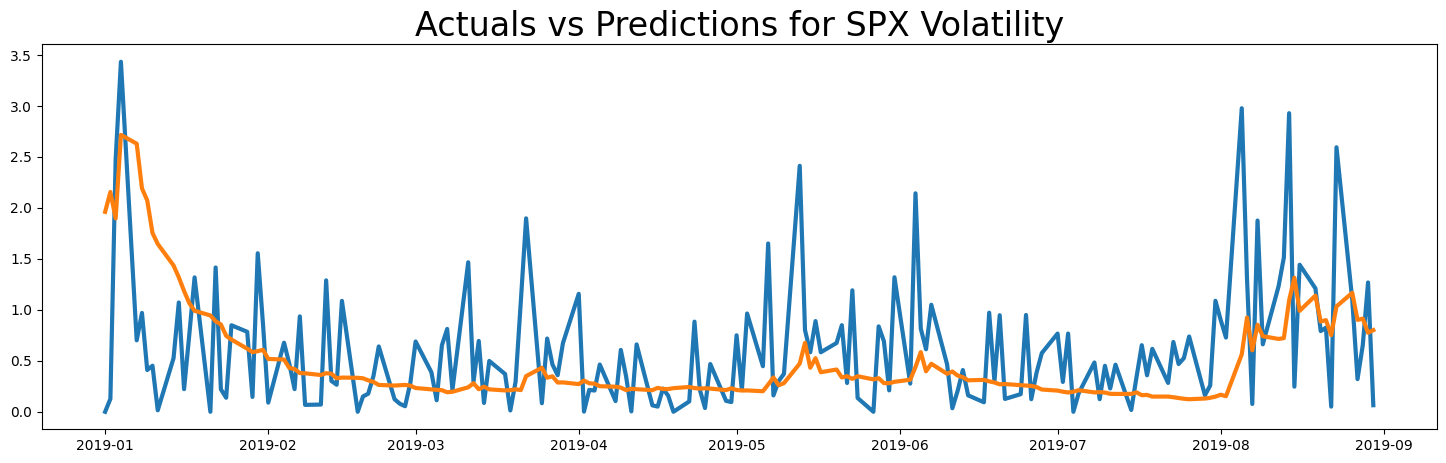

In [68]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["spx_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for SPX Volatility", size=24)

plt.show()

In [69]:
import numpy as np
from sklearn.metrics import mean_squared_error

mean_squared_error(
    predictions_df["spx_vol"].abs(), predictions_df["Predictions"]
)

0.4209119121422687

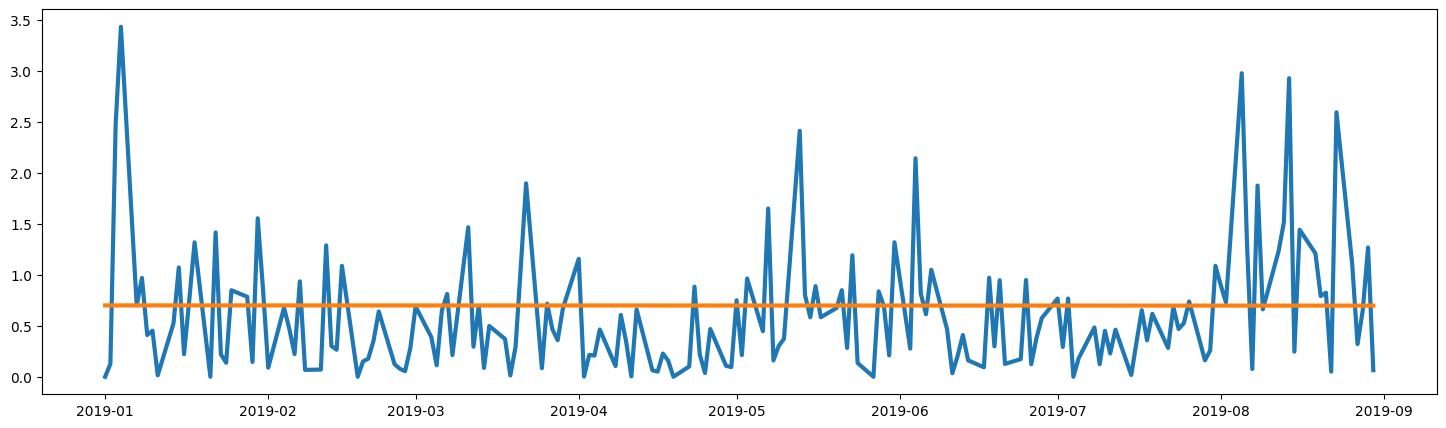

In [70]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(data["spx_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(data["spx_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["spx_vol"].fillna(0)
y_test = test_df["spx_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()

**Тестовое задание**

1. Прочитайте исходный файл с данными. Визуализируйте исходный временной ряд, сделайте первичные выводы о присутствии компонент тренда и сезонности в ряде.

Отложите последние три года из датасета как тестовую выборку для оценки результатов предсказания.
2. Постройте график скользящего среднего, проанализируйте результат. Для построения MA используйте метод rolling(), который принимает в качестве параметра размер окна. Используйте среднее как функцию для сглаживания. Ширину окна подберите самостоятельно.
Пример: train_df.spx.rolling(window=2).mean().

Визуализируйте исходный временной ряд и построенный с помощью скользящего среднего прогноз, сравните графики между собой и сделайте выводы.
3. С помощью теста Дики-Фуллера оцените стационарность временного ряда и примите решение о выборе модели ARMA/ARIMA.
Примечание. Если ваш ряд является нестационарным, дифференцируйте его до тех пор, пока он не станет таковым. Количество дифференцирований, необходимых для сведения ряда к стационарному, будет вашим параметром d для модели ARIMA.

Параметры p и q выберите по коррелограммам ACF и PACF.
Примечание. Помните, что параметры p и q для ARMA/ARIMA определяются из коррелограмм стационарного ряда. То есть, если ваш изначальный временной ряд не являлся стационарным, то коррелограммы строятся для разностей того порядка, которые являются стационарными.

Постройте модель ARMA/ARIMA для прогнозирования поведения временного ряда.

Также постройте несколько моделей с параметрами, ближайшими к найденным p и q, и сравните коэффициент AIC (или подберите наилучшие параметры с помощью пакета pmdarima, как в скринкасте).
4. Постройте модель с наилучшими параметрами и выполните предсказание для отложенной тестовой выборки (последние три года).
5. Отобразите результат графически — постройте графики истинного и предсказанного поведения временного ряда, а также 95%-ый доверительный интервал для прогноза.
6. Сделайте выводы по полученным результатам.

In [352]:
df = pd.read_csv("/content/ghana_gdp.zip", parse_dates=["year"], index_col=["year"])
df.head()

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09


In [344]:
df['GDP (current US$)'].isna().sum()

0

In [345]:
df.asfreq(freq='AS')

,GDP (current US$)
year,
1960-01-01,1.217087e+09
1961-01-01,0.000000e+00
1962-01-01,1.382353e+09
1963-01-01,1.540616e+09
1964-01-01,1.731092e+09
...,...
2017-01-01,6.040638e+10
2018-01-01,6.729928e+10
2019-01-01,6.833754e+10


In [124]:
#df['GDP (current US$)'] = df['GDP (current US$)'].apply(lambda x: np.nan if x==0 else x)

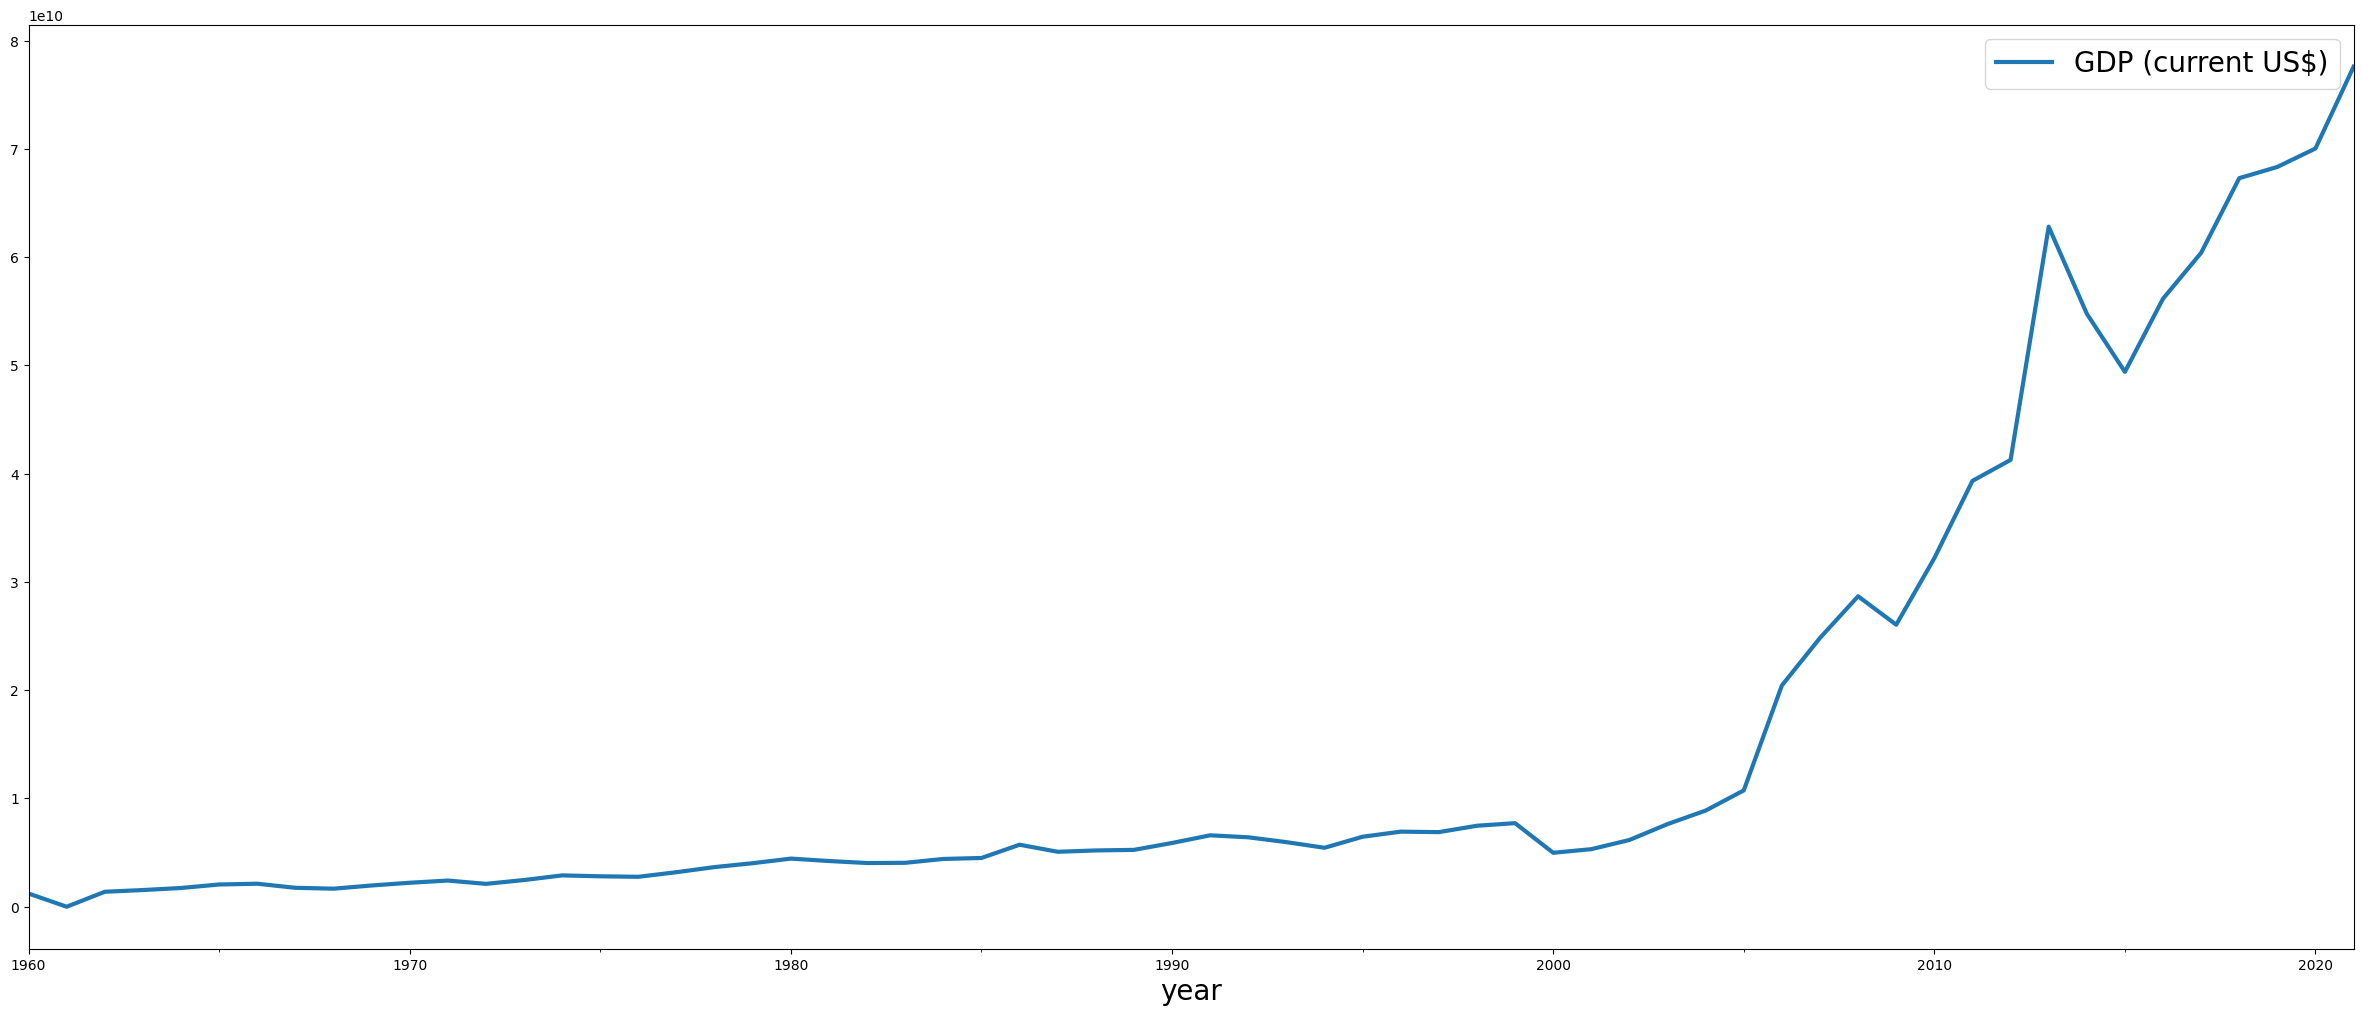

In [353]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.rcParams["figure.figsize"] = 30, 12
plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["lines.linewidth"] = 3

df.plot()
plt.show()

In [354]:
train_df = df.loc[:"2018-12-31"]
test_df = df.loc["2019-01-01":]
train_df.shape, test_df.shape

((59, 1), (3, 1))

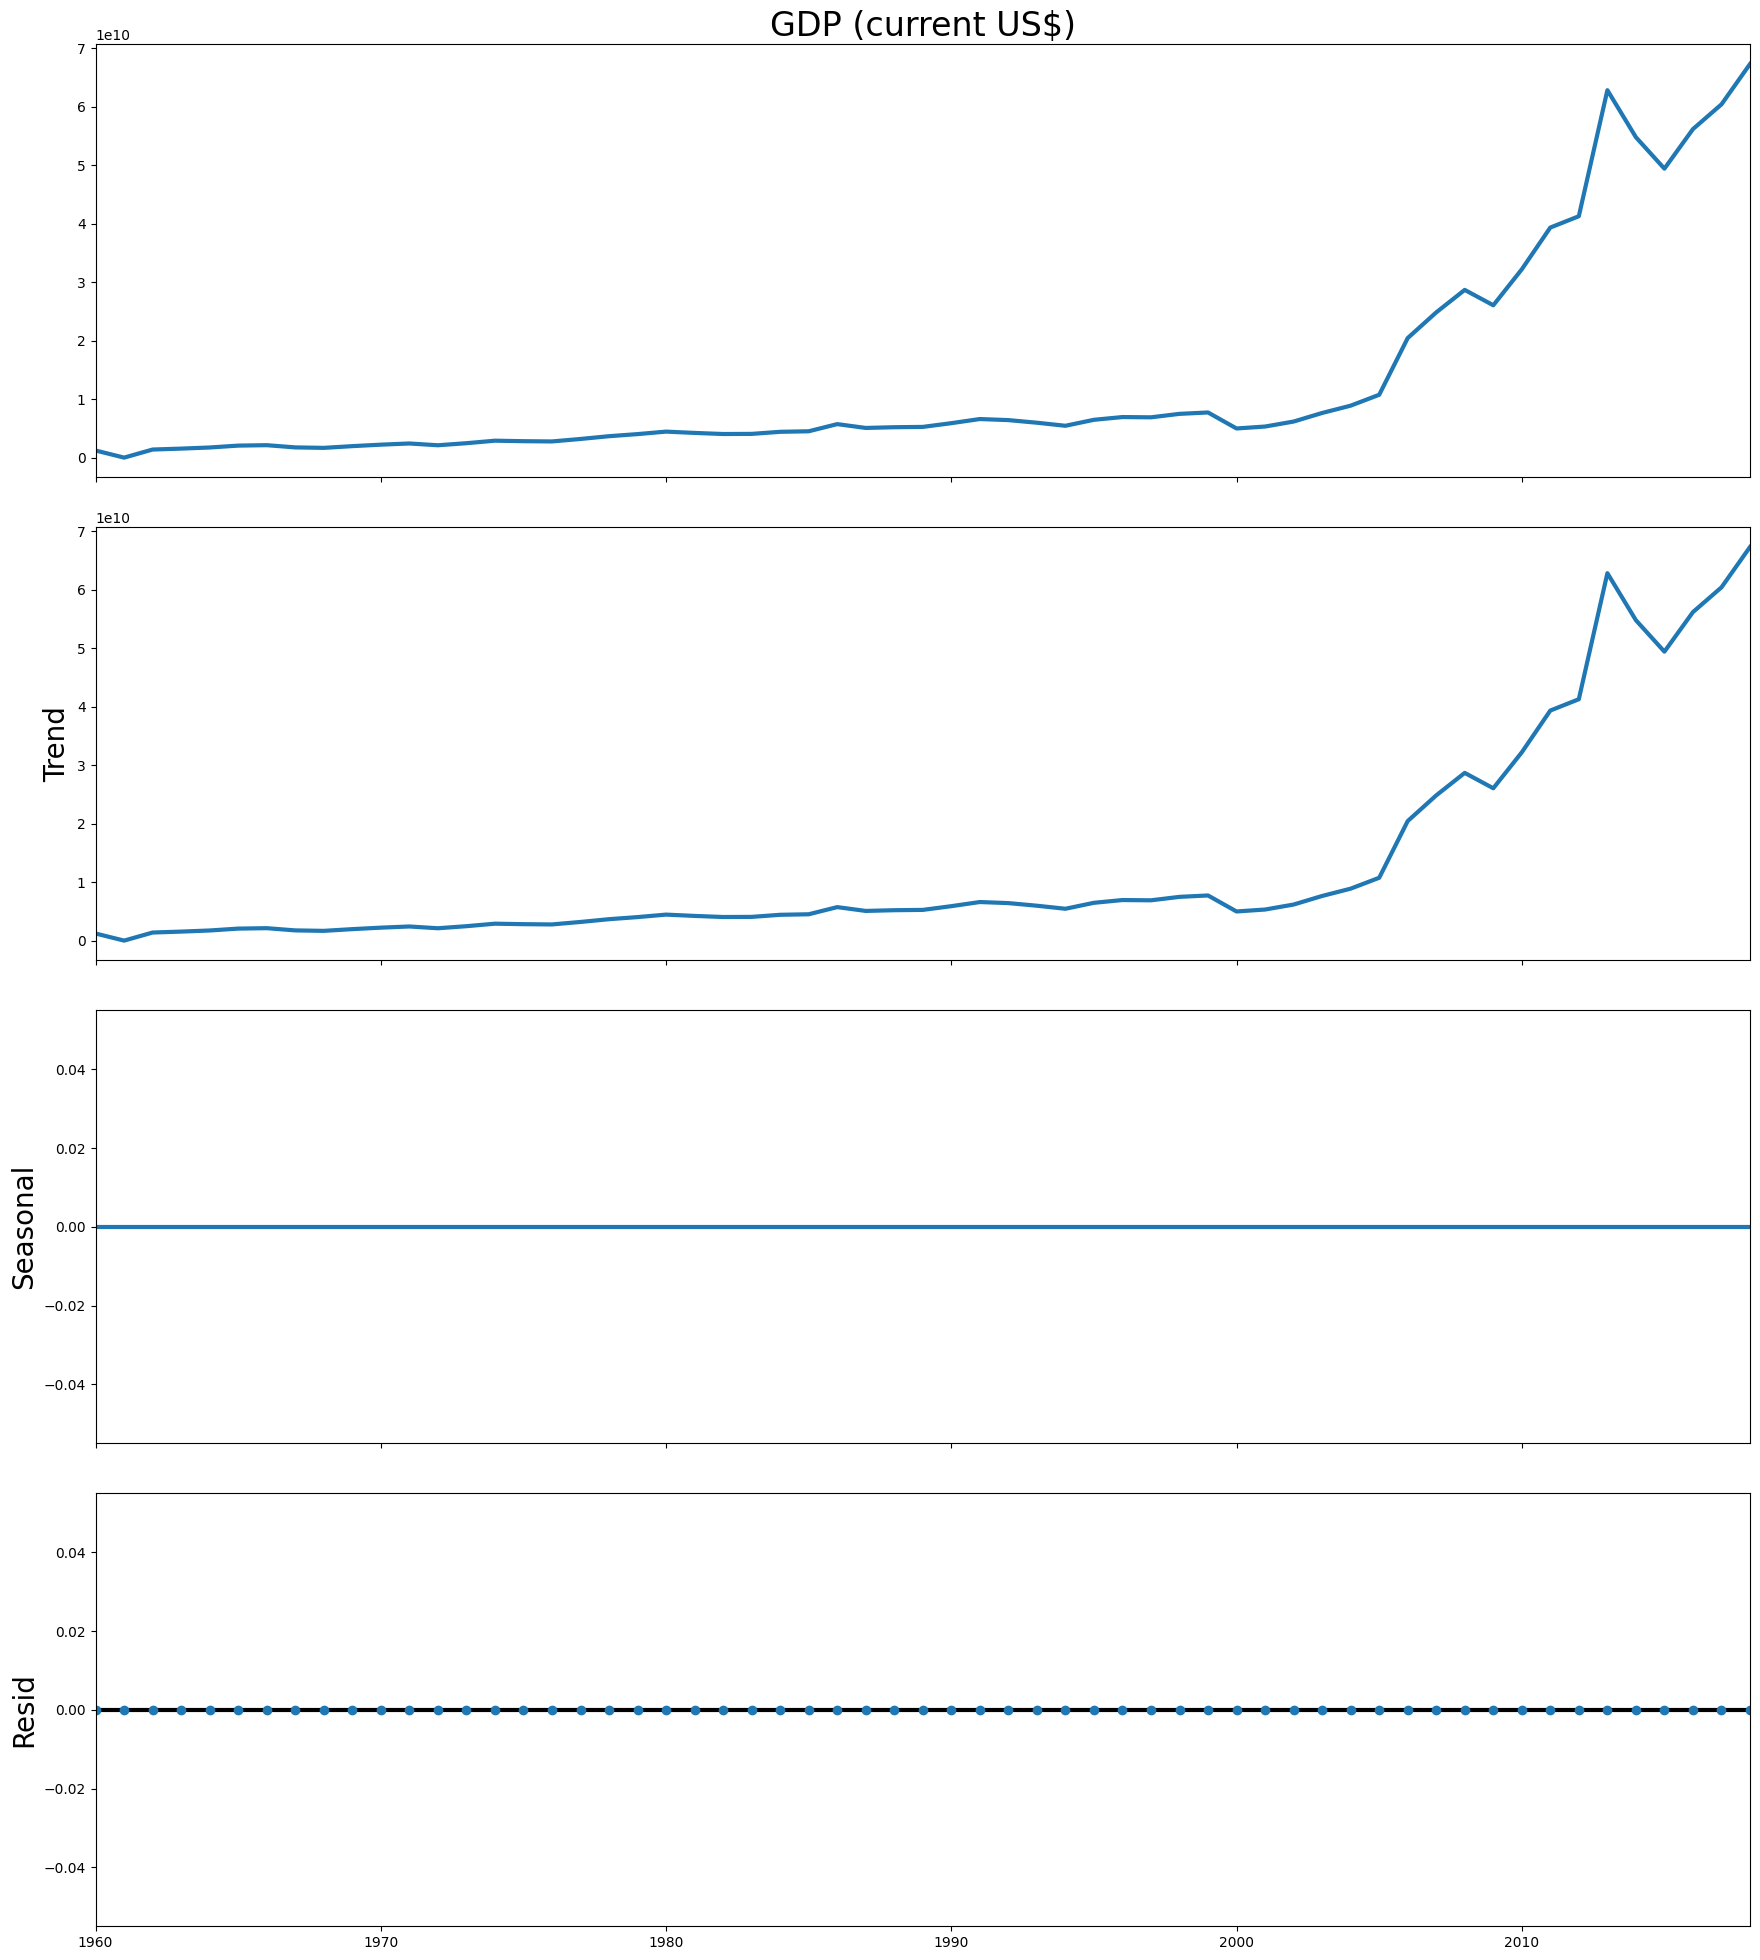

In [355]:
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams["figure.figsize"] = 18, 20

result = seasonal_decompose(train_df['GDP (current US$)'])
result.plot()
plt.show()

Выводы: тренд на ускоряющийся рост в последние три года, сезонности нет

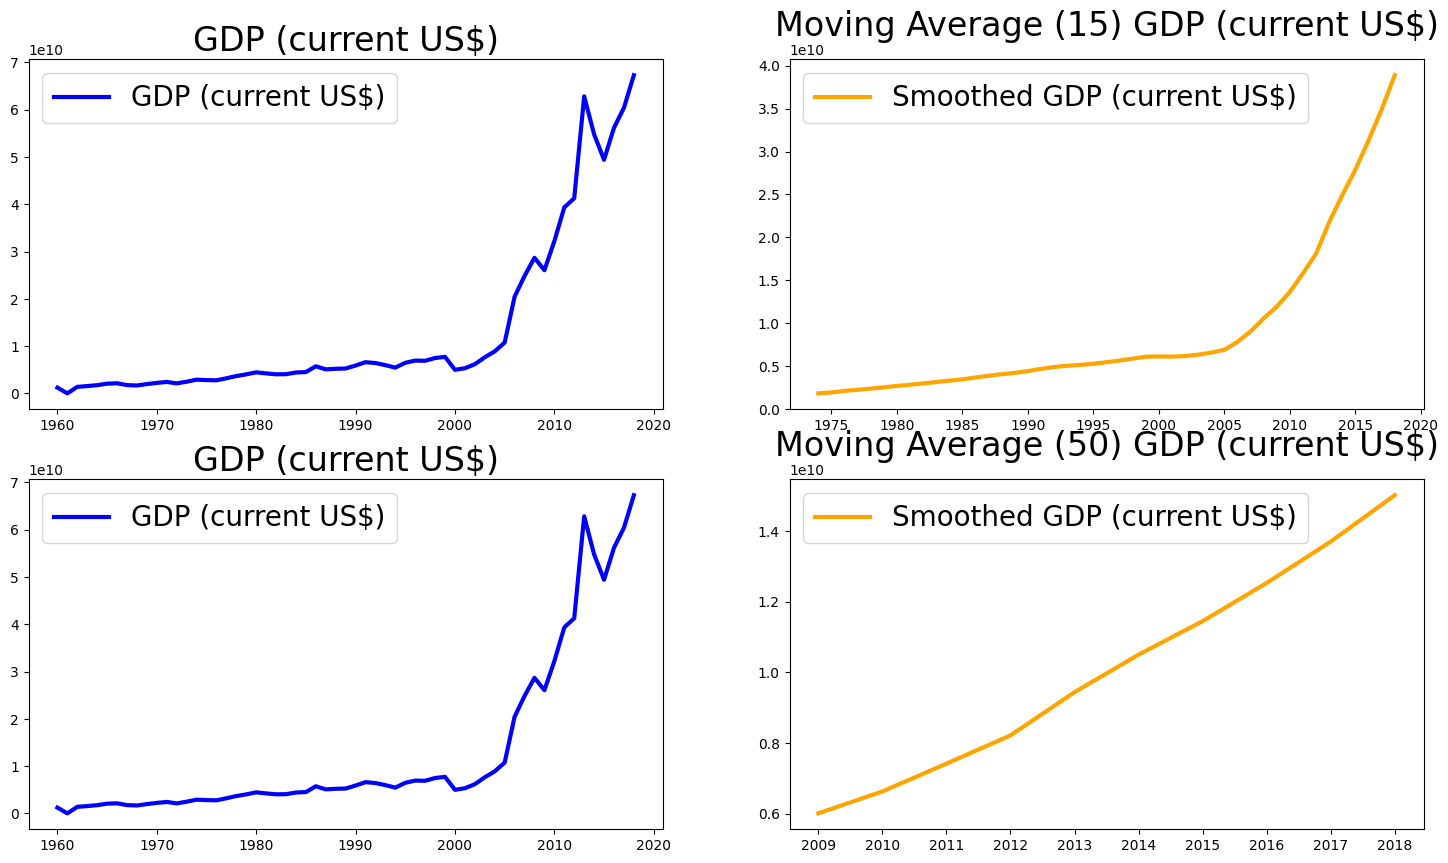

In [356]:
plt.rcParams["figure.figsize"] = 18, 10

fig, ax = plt.subplots(2, 2)

# Окно в месяц (Window = 30)
ax[0, 0].plot(train_df['GDP (current US$)'], color="blue", label="GDP (current US$)")
ax[0, 0].set_title("GDP (current US$)", size=24)
ax[0, 0].legend()

ax[0, 1].plot(
    train_df['GDP (current US$)'].rolling(window=15).mean(),
    color="orange",
    label="Smoothed GDP (current US$)",
)

ax[0, 1].set_title("Moving Average (15) GDP (current US$)", size=24)
ax[0, 1].legend()


# Окно в год (Window = 50)
ax[1, 0].plot(train_df['GDP (current US$)'], color="blue", label="GDP (current US$)")
ax[1, 0].set_title("GDP (current US$)", size=24)
ax[1, 0].legend()

ax[1, 1].plot(
    train_df['GDP (current US$)'].rolling(window=50).mean(),
    color="orange",
    label="Smoothed GDP (current US$)",
)

ax[1, 1].set_title("Moving Average (50) GDP (current US$)", size=24)
ax[1, 1].legend()

plt.show()

Выводы тренд и так явный, поэтому скользящая средняя не сильно помогает.

In [357]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df["GDP (current US$)"])

(0.6529066974885405,
 0.9888496277665573,
 10,
 48,
 {'1%': -3.5745892596209488,
  '5%': -2.9239543084490744,
  '10%': -2.6000391840277777},
 2194.301372914139)

временной ряд нестационарный

In [358]:
import pmdarima as pm

smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2491.818, Time=0.19 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2499.375, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2493.844, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2493.273, Time=0.05 sec
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=inf, Time=0.11 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=2493.722, Time=0.37 sec
 ARIMA(1,1,1)(0,1,2)[5]             : AIC=2493.670, Time=0.37 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(1,1,2)[5]             : AIC=2495.817, Time=0.45 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=2492.547, Time=0.05 sec
 ARIMA(2,1,1)(0,1,1)[5]             : AIC=2490.649, Time=0.21 sec
 ARIMA(2,1,1)(0,1,0)[5]             : AIC=2497.730, Time=0.17 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=2492.646, Time=0.31 sec
 ARIMA(2,1,1)(0,1,2)[5]             : AIC=2492.644, Time=0.37 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.137
Date:                                Sun, 10 Dec 2023   AIC                           2486.274
Time:                                        18:42:02   BIC                           2502.036
Sample:                                    01-01-1960   HQIC                          2492.335
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4208      0.148     -2.839      0.005      -0.711      -0.130
ar.L2         -0.9984      0.191     -5.241      0.000      -1.372      -0.625
ma.L1          0.3697      0.244      1.518      0.129      -0.108       0.847
ma.L2          0.9200      0.214      4.303      0.000       0.501       1.339
ma.L3          0.4151      0.197      2.110      0.035       0.029       0.801
ma.S.L5        0.0468      0.271      0.173      0.863      -0.484       0.577
ma.S.L10      -0.4534      0.314     -1.445      0.148      -1.068       0.161
sigma2      1.363e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                72.90
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              63.18   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.62e+53. Standard errors may be unstable.
"""

лучший параметр ARIMA(2,1,3)(0,1,2)[5]   

In [359]:
from statsmodels.tsa.arima.model import ARIMA

arima_model = ARIMA(train_df["GDP (current US$)"].dropna(), order=(2, 1, 3))
arima_model_fit = arima_model.fit()
arima_model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:      GDP (current US$)   No. Observations:                   59
Model:                 ARIMA(2, 1, 3)   Log Likelihood               -1355.106
Date:                Sun, 10 Dec 2023   AIC                           2722.212
Time:                        18:42:23   BIC                           2734.575
Sample:                    01-01-1960   HQIC                          2727.028
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4819      0.164      2.938      0.003       0.160       0.803
ar.L2          0.3091      0.219      1.412      0.158      -0.120       0.738
ma.L1         -0.6255      0.234     -2.671      0.008      -1.085      -0.166
ma.L2         -0.6982      0.256     -2.729      0.006      -1.200      -0.197
ma.L3          0.8558      0.082     10.452      0.000       0.695       1.016
sigma2        1.4e+19   2.56e-20   5.47e+38      0.000     1.4e+19     1.4e+19
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               143.11
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):             118.83   Skew:                             1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.43e+54. Standard errors may be unstable.
"""

In [360]:
pred_df = pd.DataFrame(index=df.index)

pred_df["model_preds"] = seas_model_fit.predict(
    start=test_df.index[0], end=test_df.index[-1]
)


pred_df["GDP (current US$)"] = df["GDP (current US$)"]

forecast = seas_model_fit.get_forecast(len(test_df.index))
forecast_df = forecast.conf_int(alpha=0.05)  # Confidence level of 95%

pred_df.at[test_df.index, "model_preds_lower"] = forecast_df["lower spx"]
pred_df.at[test_df.index, "model_preds_upper"] = forecast_df["upper spx"]

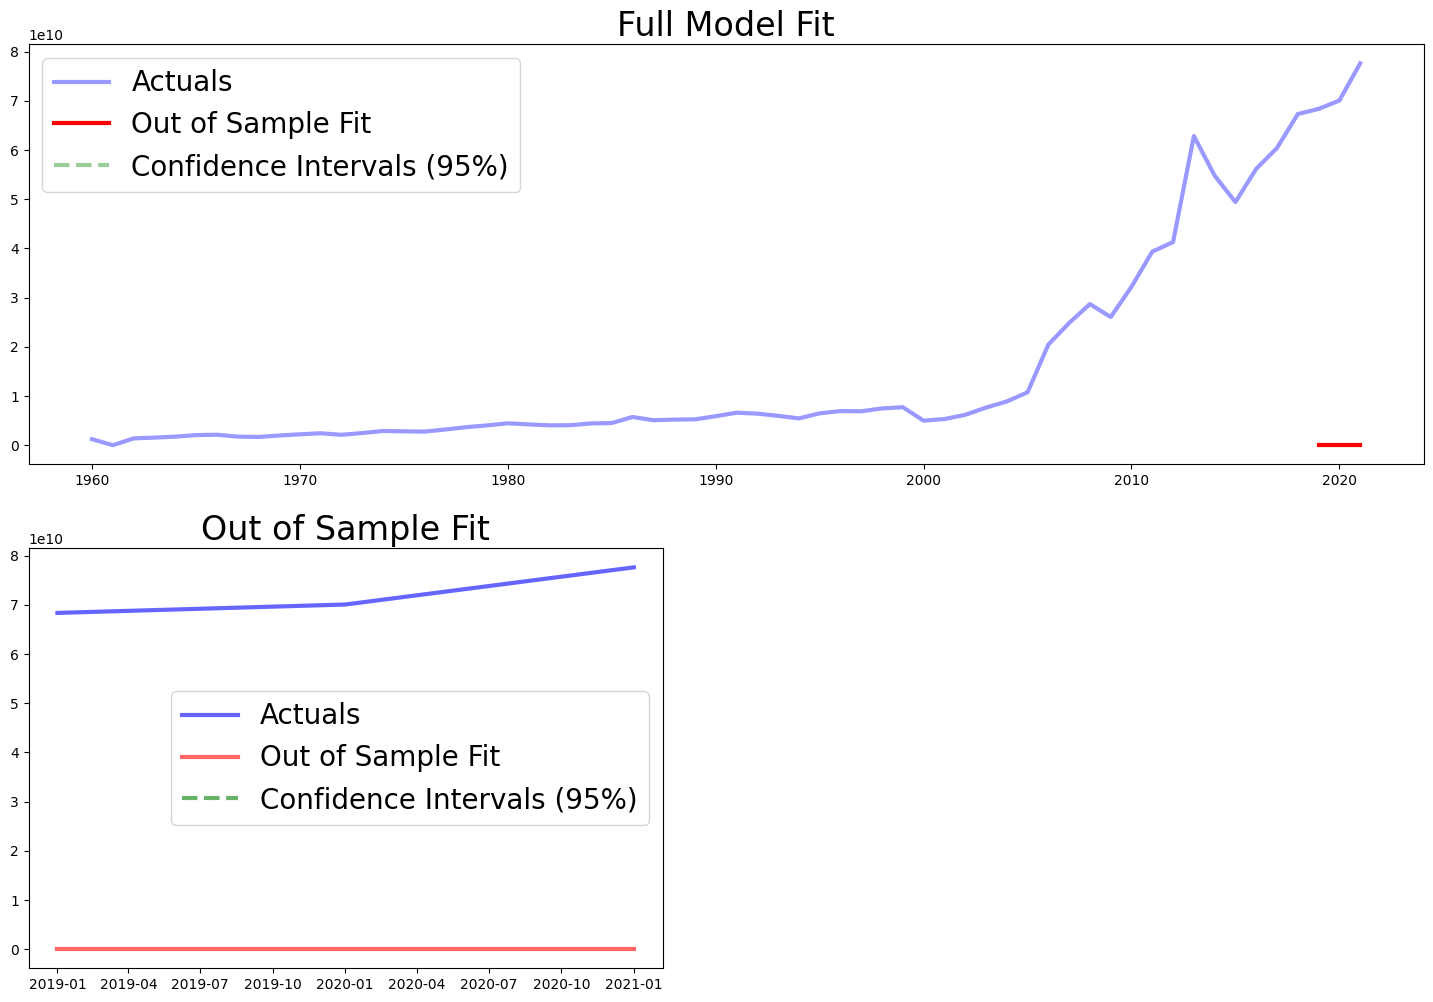

In [288]:
plt.rcParams["figure.figsize"] = 18, 12

plt.subplot(2, 1, 1)
plt.plot(pred_df["GDP (current US$)"], color="blue", label="Actuals", alpha=0.4)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.4,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.4,
)

plt.title("Full Model Fit", size=24)
plt.legend()

plt.subplot(2, 2, 3)

plt.plot(
    pred_df.loc[test_df.index]["GDP (current US$)"], color="blue", label="Actuals", alpha=0.6
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds"],
    color="red",
    linestyle="-",
    label="Out of Sample Fit",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_lower"],
    color="green",
    linestyle="--",
    label="Confidence Intervals (95%)",
    alpha=0.6,
)

plt.plot(
    pred_df.loc[test_df.index]["model_preds_upper"],
    color="green",
    linestyle="--",
    alpha=0.6,
)

plt.title("Out of Sample Fit", size=24)
plt.legend()

plt.show()

не достатчно понятный прогноз

In [350]:
df['GDP (current US$)'].interpolate(method='linear')

year
1960-01-01    1.217087e+09
1961-01-01    0.000000e+00
1962-01-01    1.382353e+09
1963-01-01    1.540616e+09
1964-01-01    1.731092e+09
                  ...     
2017-01-01    6.040638e+10
2018-01-01    6.729928e+10
2019-01-01    6.833754e+10
2020-01-01    7.004320e+10
2021-01-01    7.759428e+10
Name: GDP (current US$), Length: 62, dtype: float64

In [361]:
smodel = pm.auto_arima(
    train_df,
    start_p=1,
    d=1,
    start_q=1,
    max_p=3,
    max_q=3,
    D=1,
    start_P=0,
    m=5,
    test="adf",
    error_action="ignore",
    trace=True,
)

smodel.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[5]             : AIC=2491.818, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[5]             : AIC=2499.375, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[5]             : AIC=2493.844, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[5]             : AIC=2493.273, Time=0.07 sec
 ARIMA(1,1,1)(0,1,0)[5]             : AIC=inf, Time=0.07 sec
 ARIMA(1,1,1)(1,1,1)[5]             : AIC=2493.722, Time=0.36 sec
 ARIMA(1,1,1)(0,1,2)[5]             : AIC=2493.670, Time=0.37 sec
 ARIMA(1,1,1)(1,1,0)[5]             : AIC=inf, Time=0.13 sec
 ARIMA(1,1,1)(1,1,2)[5]             : AIC=2495.817, Time=0.46 sec
 ARIMA(1,1,0)(0,1,1)[5]             : AIC=2492.547, Time=0.05 sec
 ARIMA(2,1,1)(0,1,1)[5]             : AIC=2490.649, Time=0.20 sec
 ARIMA(2,1,1)(0,1,0)[5]             : AIC=2497.730, Time=0.18 sec
 ARIMA(2,1,1)(1,1,1)[5]             : AIC=2492.646, Time=0.35 sec
 ARIMA(2,1,1)(0,1,2)[5]             : AIC=2492.644, Time=0.59 sec
 ARIMA(2,1,1)(1,1,0)[5]             : AIC=i

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                   59
Model:             SARIMAX(2, 1, 3)x(0, 1, [1, 2], 5)   Log Likelihood               -1235.137
Date:                                Sun, 10 Dec 2023   AIC                           2486.274
Time:                                        18:43:46   BIC                           2502.036
Sample:                                    01-01-1960   HQIC                          2492.335
                                         - 01-01-2018                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4208      0.148     -2.839      0.005      -0.711      -0.130
ar.L2         -0.9984      0.191     -5.241      0.000      -1.372      -0.625
ma.L1          0.3697      0.244      1.518      0.129      -0.108       0.847
ma.L2          0.9200      0.214      4.303      0.000       0.501       1.339
ma.L3          0.4151      0.197      2.110      0.035       0.029       0.801
ma.S.L5        0.0468      0.271      0.173      0.863      -0.484       0.577
ma.S.L10      -0.4534      0.314     -1.445      0.148      -1.068       0.161
sigma2      1.363e+19        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                72.90
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):              63.18   Skew:                             0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.62e+53. Standard errors may be unstable.
"""

Данные практически не изменились

In [363]:
df["GDP (current US$)_vol"] = df['GDP (current US$)'].pct_change(1).mul(100).abs()
df["GDP (current US$)_vol"].head()

year
1960-01-01           NaN
1961-01-01    100.000000
1962-01-01           inf
1963-01-01     11.448835
1964-01-01     12.363636
Name: GDP (current US$)_vol, dtype: float64

In [364]:
df=df.drop(index=['1960-01-01','1962-01-01'])

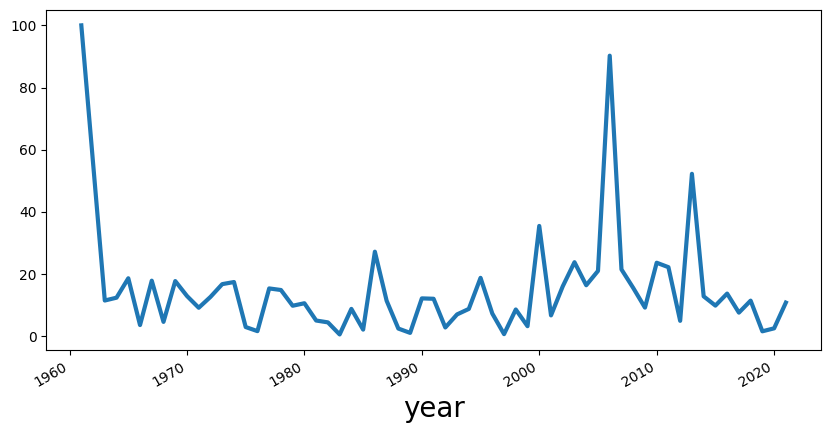

In [365]:
df["GDP (current US$)_vol"].plot()
plt.show()

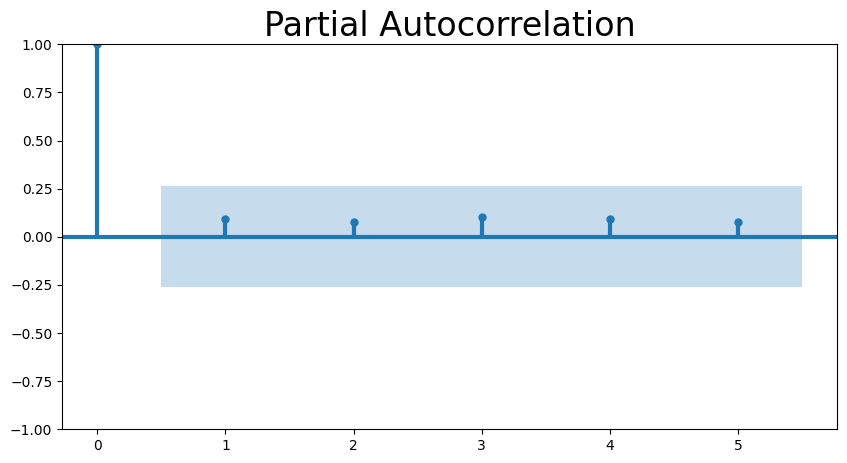

In [366]:
from matplotlib import pyplot as plt

train_df = df.loc[:"2018-12-31"]
test_df = df.loc["2019-01-01":]

plt.rcParams["figure.figsize"] = 10, 5

sgt.plot_pacf(train_df['GDP (current US$)_vol'][1:], lags=5, method="ywm")
plt.show()

In [368]:
from statsmodels.tsa.stattools import adfuller

adfuller(train_df['GDP (current US$)_vol'])

(-9.147684303794897,
 2.7397034560072583e-15,
 0,
 56,
 {'1%': -3.552928203580539,
  '5%': -2.9147306250000002,
  '10%': -2.595137155612245},
 375.4589211344782)

In [ ]:
стационарный

In [322]:
garch_df = pd.DataFrame(df["GDP (current US$)_vol"].loc[df.index])
garch_df.loc[train_df.index, "GDP (current US$)_vol"] = train_df["GDP (current US$)_vol"].dropna()

In [323]:
from arch import arch_model

model = arch_model(garch_df["GDP (current US$)_vol"].dropna(), p=1, q=1 )
model_results = model.fit(last_obs=test_df.index[0], update_freq=5)

Iteration:      5,   Func. Count:     27,   Neg. LLF: 240.12415044175157
Iteration:     10,   Func. Count:     52,   Neg. LLF: 240.10810024760238
Iteration:     15,   Func. Count:     77,   Neg. LLF: 239.7328173868933
Optimization terminated successfully    (Exit mode 0)
            Current function value: 239.71952515737507
            Iterations: 18
            Function evaluations: 92
            Gradient evaluations: 18


In [324]:
model_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Constant Mean - GARCH Model Results                       
=================================================================================
Dep. Variable:     GDP (current US$)_vol   R-squared:                       0.000
Mean Model:                Constant Mean   Adj. R-squared:                  0.000
Vol Model:                         GARCH   Log-Likelihood:               -239.720
Distribution:                     Normal   AIC:                           487.439
Method:               Maximum Likelihood   BIC:                           495.611
                                           No. Observations:                   57
Date:                   Sun, Dec 10 2023   Df Residuals:                       56
Time:                           17:48:51   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            14.5117      2.338      6.207  5.388e-10 [  9.930, 19.094]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega         58.9312     32.484      1.814  6.966e-02    [ -4.737,1.226e+02]
alpha[1]   7.2705e-09  2.069e-02  3.514e-07      1.000 [-4.055e-02,4.055e-02]
beta[1]        0.7144      0.131      5.453  4.957e-08      [  0.458,  0.971]
=============================================================================

Covariance estimator: robust
"""

In [327]:
predictions_df = test_df.copy()
predictions_df["Predictions"] = model_results.forecast().residual_variance.loc[
    test_df.index
]

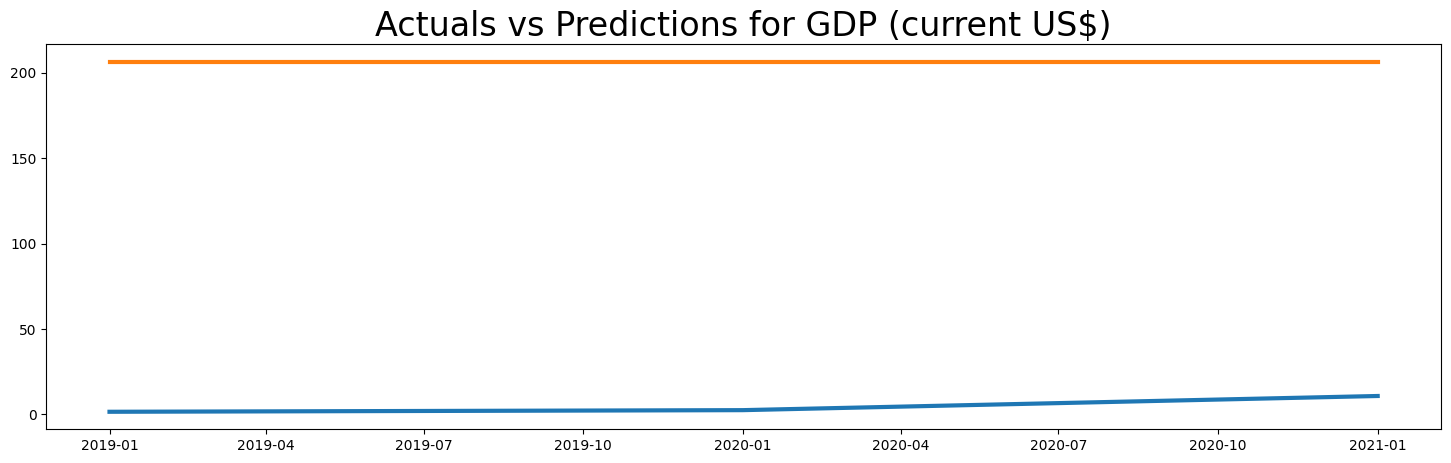

In [367]:
plt.rcParams["figure.figsize"] = 18, 5

plt.plot(predictions_df["GDP (current US$)_vol"].abs())
plt.plot(predictions_df["Predictions"])

plt.title("Actuals vs Predictions for GDP (current US$)", size=24)

plt.show()

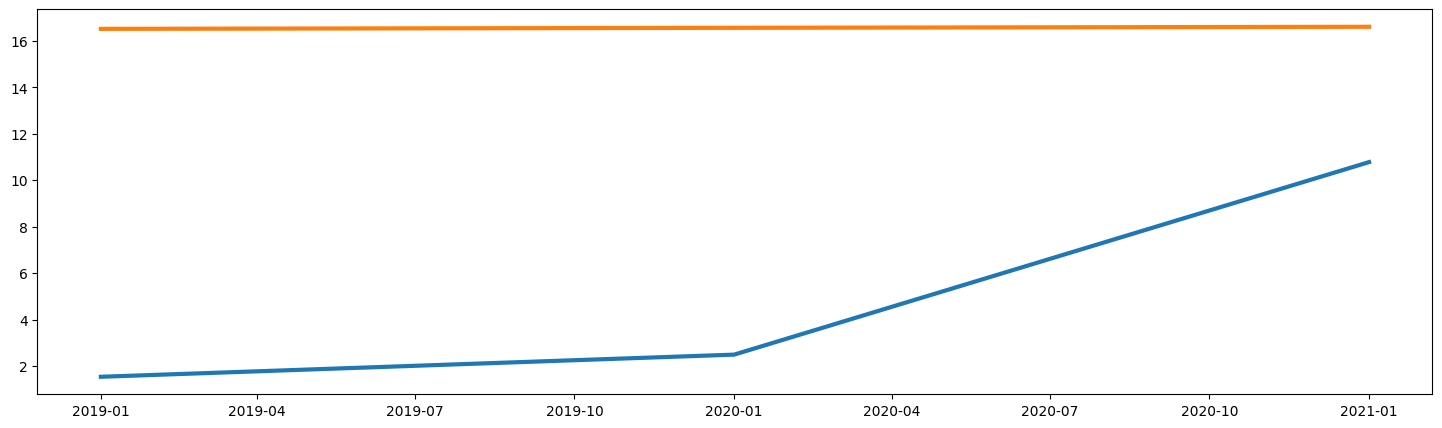

In [331]:
from sklearn.linear_model import LinearRegression

X_train = pd.DataFrame(range(df["GDP (current US$)_vol"].shape[0]))[
    : train_df.shape[0]
].fillna(0)
X_test = pd.DataFrame(range(df["GDP (current US$)_vol"].shape[0]))[
    train_df.shape[0] :
].fillna(0)
y_train = train_df["GDP (current US$)_vol"].fillna(0)
y_test = test_df["GDP (current US$)_vol"].fillna(0)


lr = LinearRegression()
lr.fit(X_train, y_train)
lr_predict = lr.predict(X_test)


plt.plot(y_test)
plt.plot(pd.Series(lr_predict, index=y_test.index))
plt.show()